# UMAPs Neurips samples, NK cells

Gene sets representing highly expressed genes in different NK cell subpopulations (defined in Yang et al., paper) are visualized in this notebook. 

RNA counts are ... normalized....

Reference: Yang, C., Siebert, J. R., Burns, R., Gerbec, Z. J., Bonacci, B., Rymaszewski, A., Rau, M., Riese, M. J., Rao, S., Carlson, K. S., Routes, J. M., Verbsky, J. W., Thakar, M. S., & Malarkannan, S. (2019). Heterogeneity of human bone marrow and blood natural killer cells defined by single-cell transcriptome. Nature communications, 10(1), 3931. https://doi.org/10.1038/s41467-019-11947-7

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot

import warnings

warnings.filterwarnings('ignore')



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


# 1. Preparation of anndata files

In [3]:
#Neurips
adata_neurips = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [4]:
adata_neurips

AnnData object with n_obs × n_vars = 80998 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [5]:
#To find gene names

result = [i for i in adata_neurips.var_names if i.startswith('ROR')]
print(result)

['ROR1', 'ROR2', 'RORA', 'RORA-AS1', 'RORB', 'RORC']


In [6]:
adata_neurips.obs['cell_type'].unique().tolist()

['NK',
 'CD8+ T CD69+ CD45RA+',
 'NK CD158e1+',
 'HSC',
 'CD14+ Mono',
 'B1 B IGKC+',
 'CD4+ T activated',
 'CD8+ T CD69+ CD45RO+',
 'G/M prog',
 'Naive CD20+ B IGKC-',
 'CD8+ T CD49f+',
 'Naive CD20+ B IGKC+',
 'CD4+ T naive',
 'CD8+ T naive',
 'CD4+ T activated integrinB7+',
 'cDC2',
 'gdT TCRVD2+',
 'CD8+ T TIGIT+ CD45RO+',
 'CD16+ Mono',
 'Erythroblast',
 'MAIT',
 'T reg',
 'gdT CD158b+',
 'Transitional B',
 'Proerythroblast',
 'CD8+ T CD57+ CD45RO+',
 'Plasmablast IGKC+',
 'ILC1',
 'Lymph prog',
 'ILC',
 'MK/E prog',
 'Normoblast',
 'CD8+ T CD57+ CD45RA+',
 'pDC',
 'B1 B IGKC-',
 'Plasma cell IGKC-',
 'Plasmablast IGKC-',
 'Plasma cell IGKC+',
 'CD8+ T TIGIT+ CD45RA+',
 'CD8+ T naive CD127+ CD26- CD101-',
 'CD4+ T CD314+ CD45RA+',
 'cDC1',
 'T prog cycling',
 'dnT']

In [7]:
#Both NK cell types selected


neurips_nk = adata_neurips[(adata_neurips.obs['cell_type'] == "NK") | (adata_neurips.obs['cell_type'] == "NK CD158e1+")]

In [8]:
neurips_nk

View of AnnData object with n_obs × n_vars = 7388 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [9]:
neurips_nk_prot=neurips_nk.obsm['protein_expression_clr_neurips']

In [10]:
#To exclude columns that contain only zeros

neurips_nk_prot = pd.DataFrame(neurips_nk_prot)
neurips_nk_prot != 0
(neurips_nk_prot != 0).any(axis=0)
neurips_nk_prot.loc[:, (neurips_nk_prot != 0).any(axis=0)]
neurips_nk_prot = neurips_nk_prot.loc[:, (neurips_nk_prot != 0).any(axis=0)]

In [11]:
samples=adata_neurips.obs['POOL'].unique().tolist()

In [12]:
#selecting one sample from Neurips

eg=adata_neurips[adata_neurips.obs['POOL'] == "s4d1"].copy()


In [13]:
eg

AnnData object with n_obs × n_vars = 4885 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [14]:
prot=eg.obsm['protein_expression_clr_neurips']

In [15]:
prot

CD86     CD274     CD270     CD155     CD112  \
GTAGTACCAATCCTTT-1-s4d1  0.652674  1.447594  1.489354  0.890243  1.290341   
CTCAAGAGTCACAGAG-1-s4d1  0.652674  1.069339  1.657770  0.890243  1.377072   
CTGTGGGTCATGCGGC-1-s4d1  0.378666  1.132949  1.153412  0.730824  1.195368   
CGTGATAGTTATCTGG-1-s4d1  0.000000  1.249182  1.335424  1.256332  2.674106   
AGATCCAAGATCGGTG-1-s4d1  2.784459  1.132949  1.674846  1.669058  1.663981   
...                           ...       ...       ...       ...       ...   
TAGATCGTCTCTATAC-1-s4d1  0.000000  1.132949  1.358918  1.523729  1.195368   
AAGACTCAGGGCAAGG-1-s4d1  0.652674  1.302596  1.208881  0.541080  1.090419   
CGAGAAGCACCTCGTT-1-s4d1  0.378666  0.764571  1.208881  0.730824  1.494512   
TATCCTAGTTCTCCTG-1-s4d1  0.000000  1.302596  1.286711  0.890243  1.377072   
TGCCGAGCAACAAAGT-1-s4d1  0.378666  1.302596  1.786846  0.541080  1.724470   

                             CD47      CD48      CD40     CD154      CD52  \
GTAGTACCAATCCTTT-1-s4d1  1.988618  1.733474  0.850004  1.531390  0.694828   
CTCAAGAGTCACAGAG-1-s4d1  1.264995  1.863027  1.101769  1.562259  1.072649   
CTGTGGGTCATGCGGC-1-s4d1  1.546005  1.090567  1.173337  1.303511  1.013739   
CGTGATAGTTATCTGG-1-s4d1  1.322314  0.289336  1.240123  1.397398  1.525053   
AGATCCAAGATCGGTG-1-s4d1  2.101246  2.112640  1.417276  1.884321  1.861734   
...                           ...       ...       ...       ...       ...   
TAGATCGTCTCTATAC-1-s4d1  1.312986  1.077960  1.173337  1.690467  1.013739   
AAGACTCAGGGCAAGG-1-s4d1  1.589583  1.436578  1.240123  1.379313  0.561056   
CGAGAAGCACCTCGTT-1-s4d1  1.944753  2.308527  0.941152  1.342130  1.231042   
TATCCTAGTTCTCCTG-1-s4d1  1.150531  0.882414  1.469979  1.649530  0.607664   
TGCCGAGCAACAAAGT-1-s4d1  1.603697  1.857224  0.941152  1.767631  2.943224   

                         ...     HLA-E      CD82     CD101      CD88  \
GTAGTACCAATCCTTT-1-s4d1  ...  1.532575  0.614600  0.900688  1.389844   
CTCAAGAGTCACAGAG-1-s4d1  ...  1.283465  0.614600  1.786480  0.762359   
CTGTGGGTCATGCGGC-1-s4d1  ...  1.344431  0.353792  0.860303  0.979461   
CGTGATAGTTATCTGG-1-s4d1  ...  0.859205  1.527772  0.629556  0.854928   
AGATCCAAGATCGGTG-1-s4d1  ...  1.429432  1.031029  2.808629  2.007436   
...                      ...       ...       ...       ...       ...   
TAGATCGTCTCTATAC-1-s4d1  ...  1.482333  0.353792  0.576253  1.157734   
AAGACTCAGGGCAAGG-1-s4d1  ...  1.149104  0.614600  0.818218  1.189870   
CGAGAAGCACCTCGTT-1-s4d1  ...  1.184424  0.773465  0.939506  1.017749   
TATCCTAGTTCTCCTG-1-s4d1  ...  1.401893  1.405442  0.860303  1.124532   
TGCCGAGCAACAAAGT-1-s4d1  ...  1.344431  3.507507  3.029109  1.363610   

                            CD224  CD197  CD34  CD10  CD90  CD15  
GTAGTACCAATCCTTT-1-s4d1  0.918109    0.0   0.0   0.0   0.0   0.0  
CTCAAGAGTCACAGAG-1-s4d1  1.112478    0.0   0.0   0.0   0.0   0.0  
CTGTGGGTCATGCGGC-1-s4d1  1.147198    0.0   0.0   0.0   0.0   0.0  
CGTGATAGTTATCTGG-1-s4d1  1.000442    0.0   0.0   0.0   0.0   0.0  
AGATCCAAGATCGGTG-1-s4d1  2.064066    0.0   0.0   0.0   0.0   0.0  
...                           ...    ...   ...   ...   ...   ...  
TAGATCGTCTCTATAC-1-s4d1  1.304730    0.0   0.0   0.0   0.0   0.0  
AAGACTCAGGGCAAGG-1-s4d1  1.180752    0.0   0.0   0.0   0.0   0.0  
CGAGAAGCACCTCGTT-1-s4d1  1.112478    0.0   0.0   0.0   0.0   0.0  
TATCCTAGTTCTCCTG-1-s4d1  1.304730    0.0   0.0   0.0   0.0   0.0  
TGCCGAGCAACAAAGT-1-s4d1  1.868853    0.0   0.0   0.0   0.0   0.0  

[4885 rows x 139 columns]

In [16]:
prot=prot.rename(columns={'CD2': 'CD2_prot', 'CX3CR1': 'CX3CR1_prot', 'CD52': 'CD52_prot','CD69': 'CD69_prot', 'CD226':'CD226_prot', 'TIGIT':'TIGIT_prot', 'CD27':'CD27_prot', 'CD38': 'CD38_prot', 'CD224': 'CD224_prot', 'CD7': 'CD7_prot', 'CD44': 'CD44_prot', 'CD34': 'CD34_prot','CD5': 'CD5_prot'})


In [17]:
#some proteins and genes have same names, here _prot added after protein names

a = eg.obs
b = prot

adata_eg=pd.concat([a, b], axis=1)
eg.obs=adata_eg


In [18]:
#selecting NK cells, gd T cells and ILCs

sample_nk = eg[(eg.obs['cell_type'] == "NK") | (eg.obs['cell_type'] == "NK CD158e1+") | (eg.obs['cell_type'] == "ILC") | (eg.obs['cell_type'] == "gdT CD158b+")].copy()   


In [21]:
#Computing a neighborhood of observations using latent space

sc.pp.neighbors(adata_neurips, use_rep="X_totalVI")   #indicated representation

sc.tl.umap(adata_neurips)

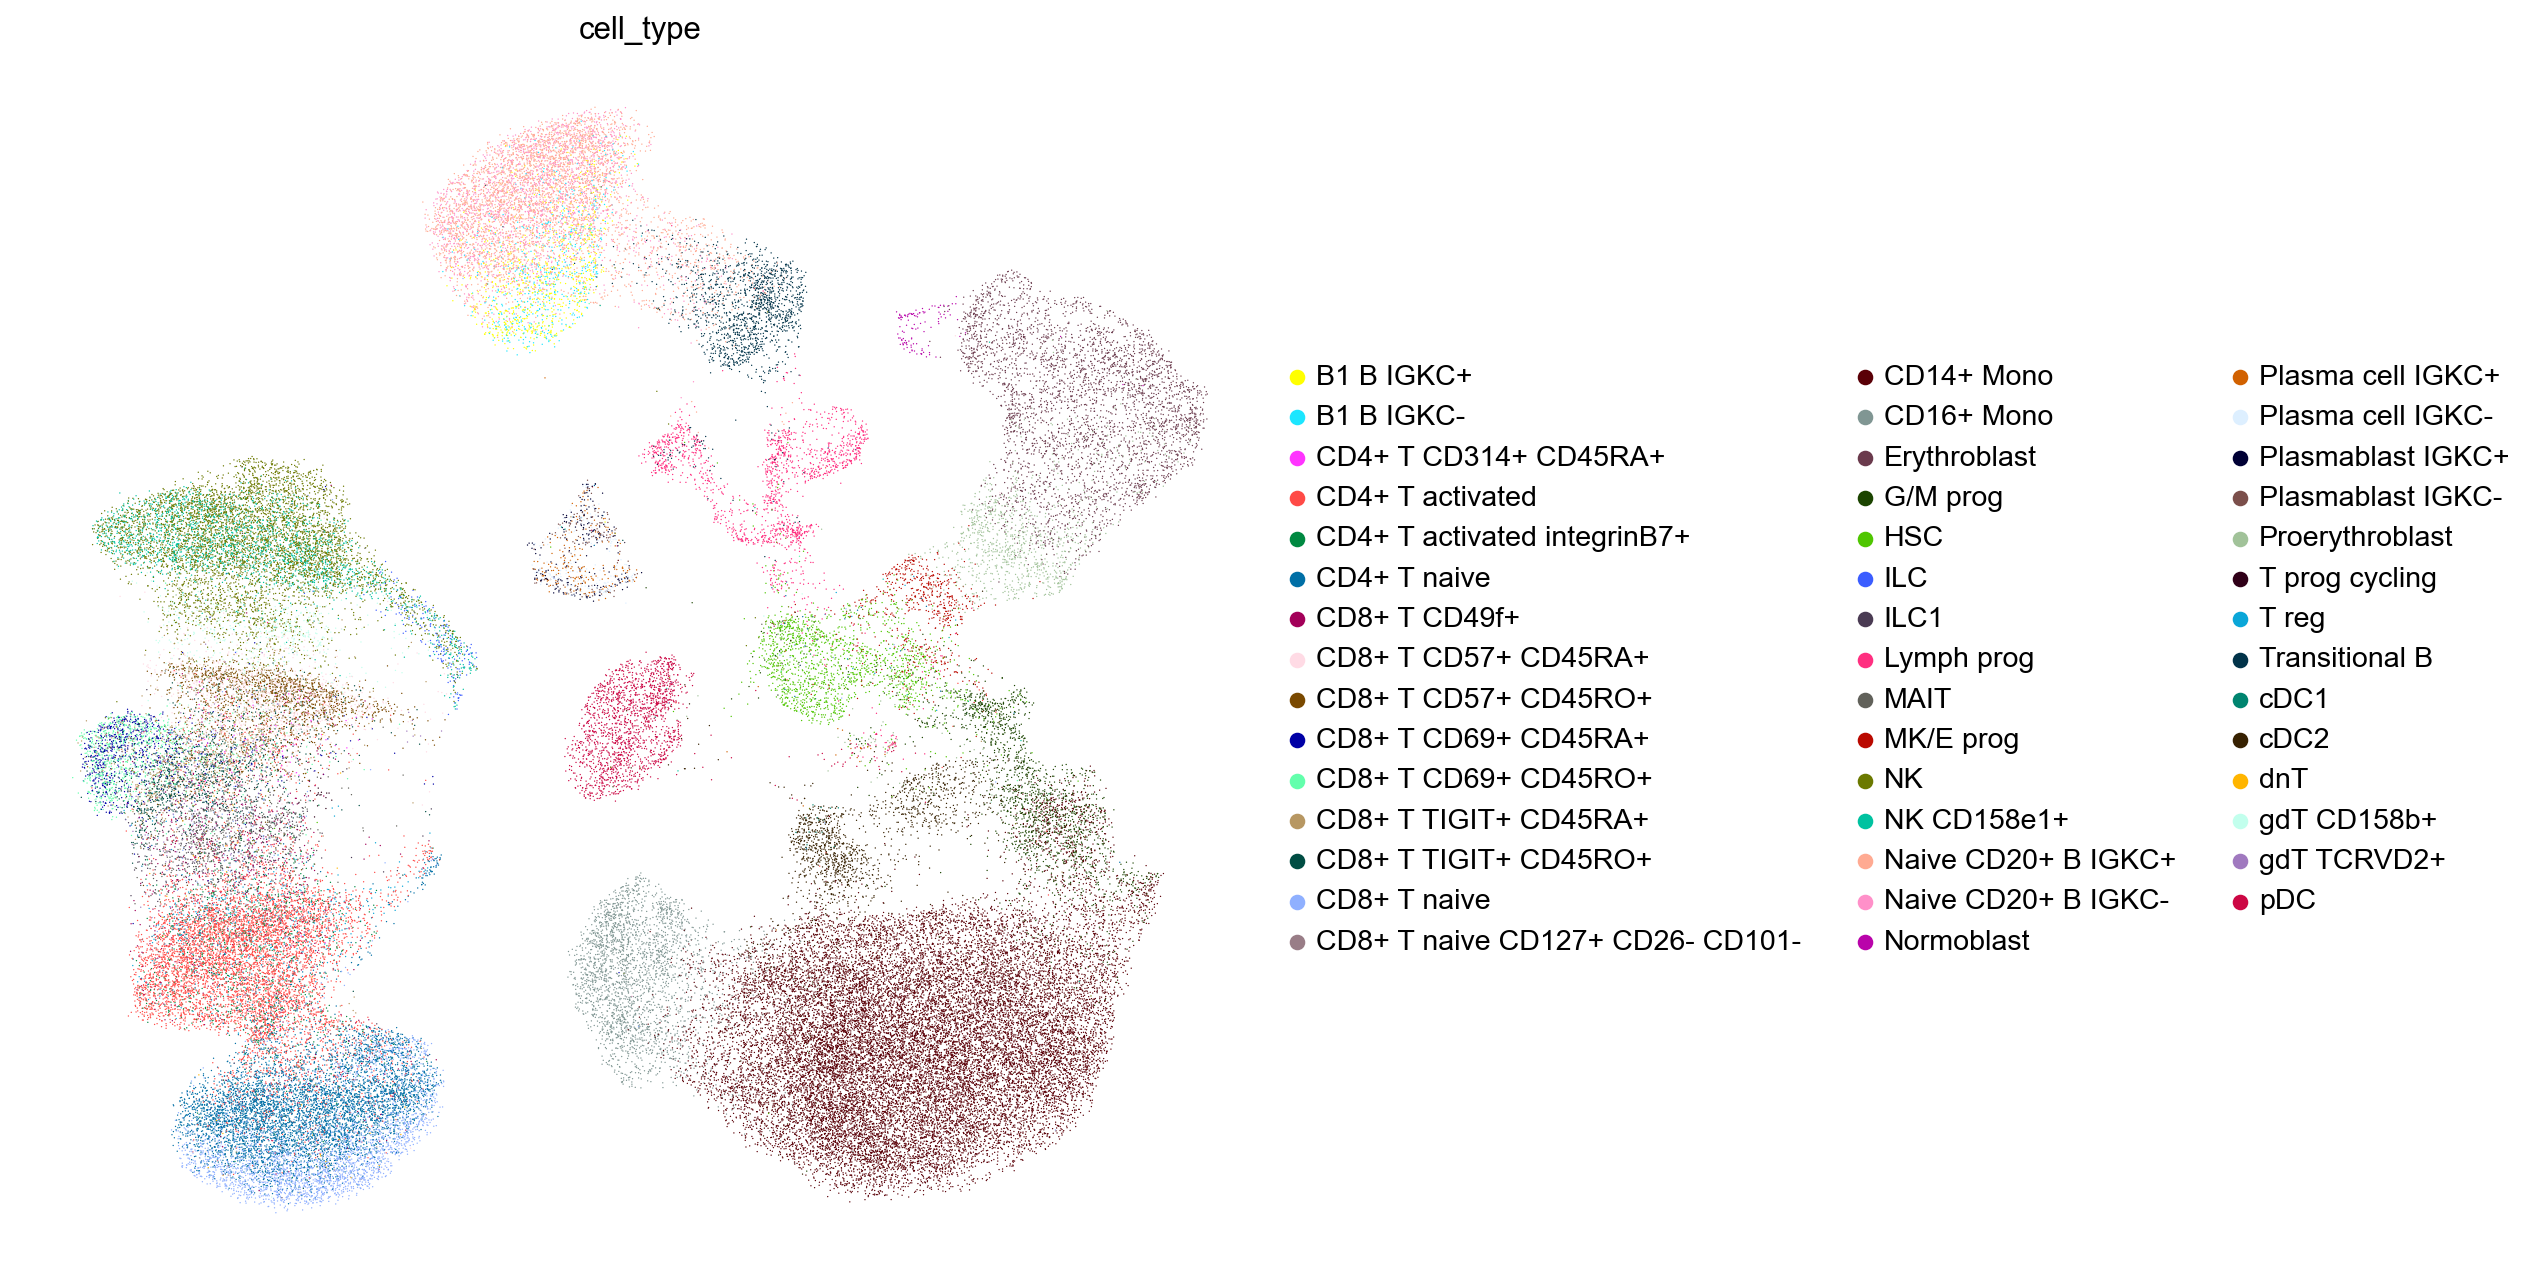

In [22]:
#Whole Neurips dataset, coloured by annotated cell types

sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_neurips, color = ['cell_type'], frameon = False)

# 2.  Markers by Yang et al. 

- sscRNA-seq on BM (n=6) and PB (n=2). In total, 5567 and 3046 NK cells from the BM and blood were analyzed. 

- Recently, the definition of the NK cell-restricted progenitor population has been redefined as Lin− CD34+CD38+CD123−CD45RA+CD7+CD10+CD127− cells as a consistent fraction of putative NK precursors in secondary lymphoid organs turn out to be ILCs or ILC progenitors

- NK cell maturation occurs mostly in secondary lymphoidal organs. The analyses of NK cells from secondary lymphoidal organs will give insights into early NK developmental stages. In this study they were not able to detect earlier development states of NK cells. 

- Markers to define NK lineage: CD94 (KLRD1), NKp80 (KLRF1), NKG7 and GNLY. NCAM1 (CD56) as well, but was not well represented in this study.

- Markers used to catch NK cells (also progenitors/ILCs): Lin−, CD7+ (not all cells yet CD56+).

- Within this Lin−, CD7+ population 90% are CD56bright NK cells.

- Remaining CD56dim/- cells: over 50% express KLRC1 (NKp80) and CD16 => mature NK cells, rest (CD7+, CD56dim/−, CD16−, NKp80−) probably ILCs, NK progenitors, immature NK cells or immature cells with multiple lineages potential.  

- maturation of  CD56dimCXCR4+ NK cells = NKG2A, CD62L, CD57


### 7 clusters from BM NK cells: #

1. CD56bright NK

2. Transitional NK (intermediate expression of signature genes of either CD56bright or CD56dimCD57+ NK cells)

3. Adaptive NK: High KLRC2 expression, only detected from BM, mostly composed of cells of one donor. Also cells from few other samples detected, not high KLRC2, but instead high CD52 expression.

4. Mature NK:  High expression of molecules important for cytotoxic function. Enrichment of gene sets, including the apical junction, regulation of actin cytoskeleton, NK cell-mediated cytotoxicity, and structure constituent of the cytoskeleton in the “Mature NK” cluster com- pared to the rest of the cells

5. Terminal NK: Mature NK and terminal NK clusters together form the CD57+ cell population. Similar transcriptional and functional profile as mature NKs, but increased expression of ZEB2,  CX3CR1 and HAVCR2 (TIM-3). Dampened signaling and metabolic profiles => quiescent state? 

6. Active NK : same features as inflamed NK. Several genes that belong to the immediate early genes (IEGs). IEGs are induced rapidly in response to stimuli without nascent protein synthesis. Active transcription, activation of several signaling pathways (KRAS-MAPK, TRAF6-NF-kappa-B. Active NK cluster is potentially within the CD56dim NK population (mature NKs) with a decreased expression of the genes encoding cytolytic proteins compared to the mature NK cluster. Maybe not unique developmental stage. 

7. Inflamed NK (mostly composed of cells of one patient, who donored BM) 


### Markers: #

- Is NK: KLRD1 (CD94), KLRF1, NKG7, GNLY, NCAM1 (CD56), CD7

- CD56brigh: IL7RA (IL7R), SELL (CD62L), NKG2A (KLRC1), GZMK, CD44, XCL1, XCL2. Minimal expression of FCGR3A (CD16), B3GAT1 (CD57) and CD160. 

- Adaptive: KLRC2 (NKG2C), CD52, CD3E/D/G. Low expresison of FcεRγ (FCER1G), SYK (SYK), EAT-2 (SH2D1B), and PLZF (ZBTB16) compared to other clusters

- Mature NK: B3GAT1 (CD57), PRF1, GZMA, GZMB, GZMH, ACTB, ARPC2, CORO1A, CFL1, CST7, PFN1, ANXA1). 

- Terminal NK: 
 - bonemarrow: ZEB2, CX3CR1 and HAVCR2 (TIM-3), WDR74, SNORD3A, TMEM107, SNORD3D, RNU12, SNORD3B-2, SNORD3B-1, C12orf57, HIST1H1E, HIST1H1C, HIST1H1D, HIST2H2BE, RNU11, JUN, PTCH2, RP11-386I14.4,CD38. 
 - Peripheral blood: MYBL1, CX3CR1, RNU12, DDX17, HIST1H1C, TMEM107, SNORD3A, NKTR, WDR74, HIST2H2BE, HIST1H1E, HIST1H1D

- Active NK: NFKBIA, JUN, JUNB, ZFP36, DOS, FOSB, DUSP1, NR4A2, CXCR4

- Inflamed NK: IFIT3, IFIT2, TNF, CD69




## 2.1 NK lineage defining markers

In [19]:
is_nk_yang = ['KLRD1', 'KLRF1', 'NKG7', 'GNLY', 'NCAM1'] #the most DE genes in NK cells

In [25]:
sc.tl.score_genes(eg, is_nk_yang, score_name = 'isnk_score')

sc.tl.score_genes(sample_nk, is_nk_yang, score_name = 'isnk_score')
sc.tl.score_genes(sample_nk, is_nk_yang, score_name = 'isnk_score')

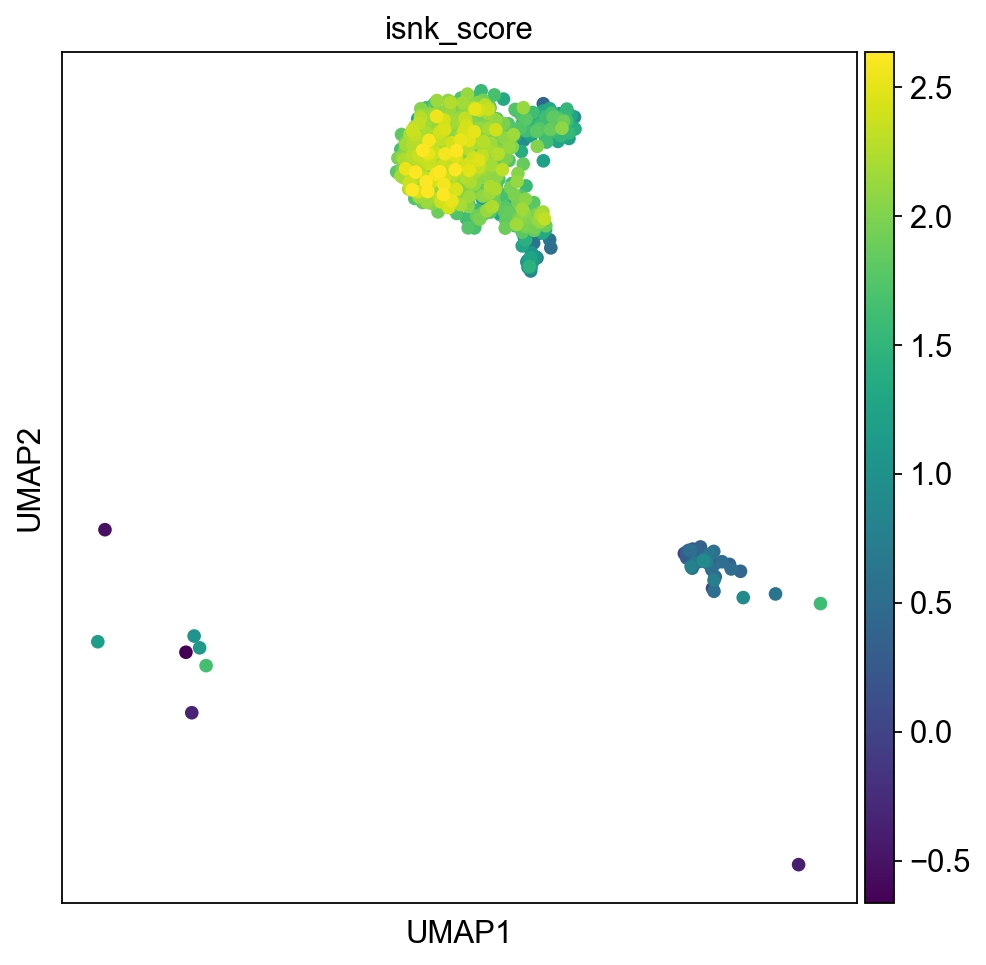

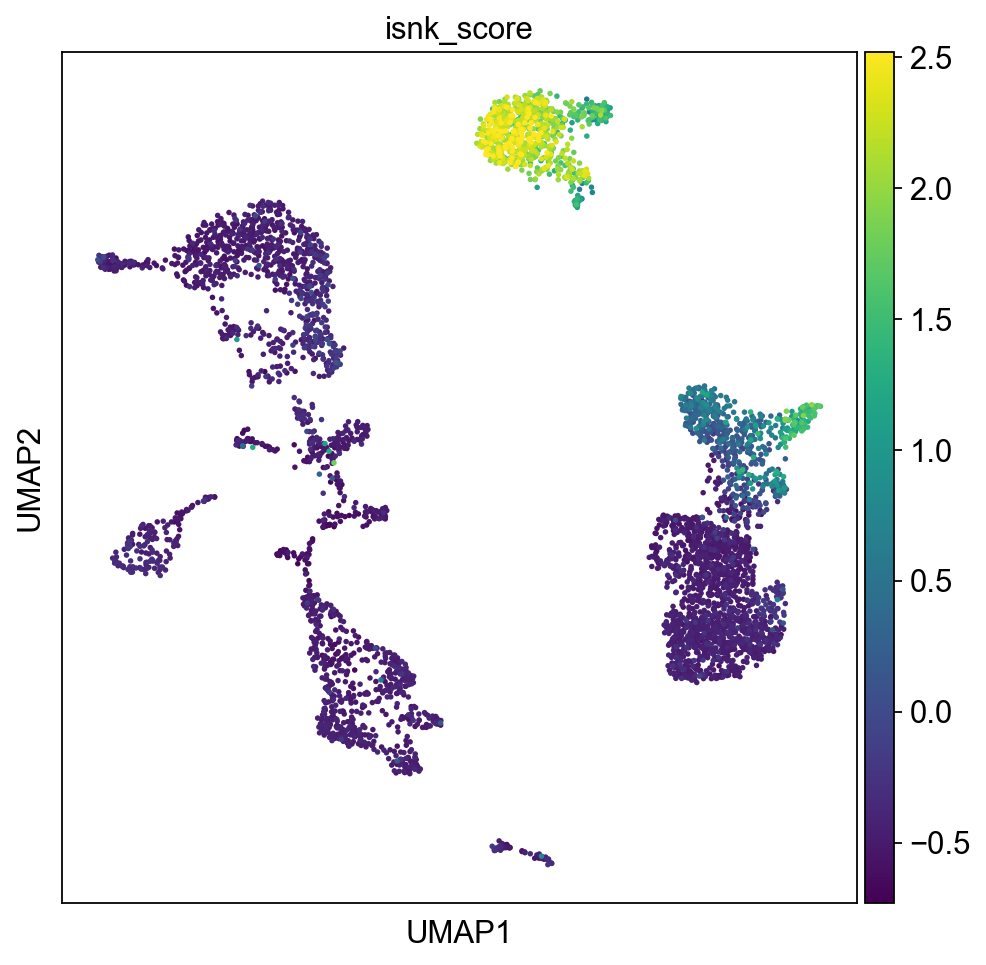

In [26]:
sc.set_figure_params(figsize=(7, 7))

sc.pl.umap(sample_nk, color = ['isnk_score'], vmax="p99", color_map = 'viridis', ncols=2)

sc.pl.umap(eg, color = ['isnk_score'], vmax="p99", color_map = 'viridis', ncols=2)



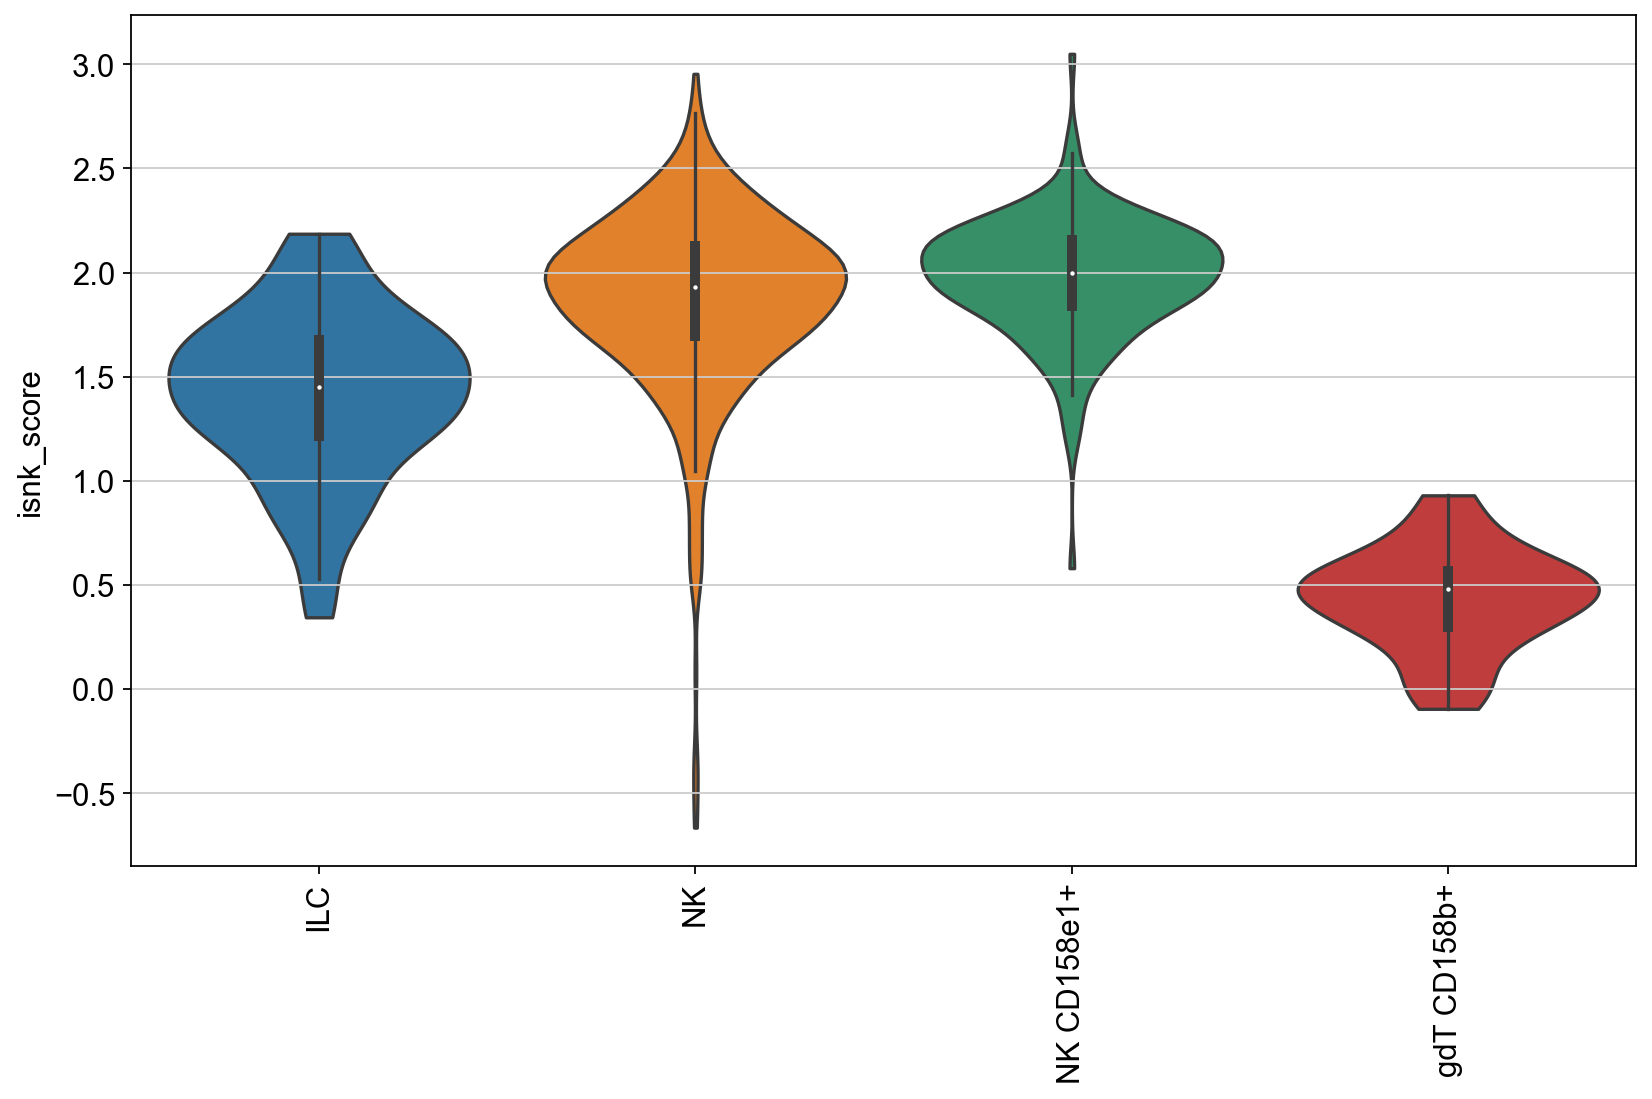

In [43]:
sc.set_figure_params(figsize=(10, 7))

sc.pl.violin(sample_nk, ['isnk_score'], groupby='cell_type', stripplot=False, inner='box', rotation=90)  



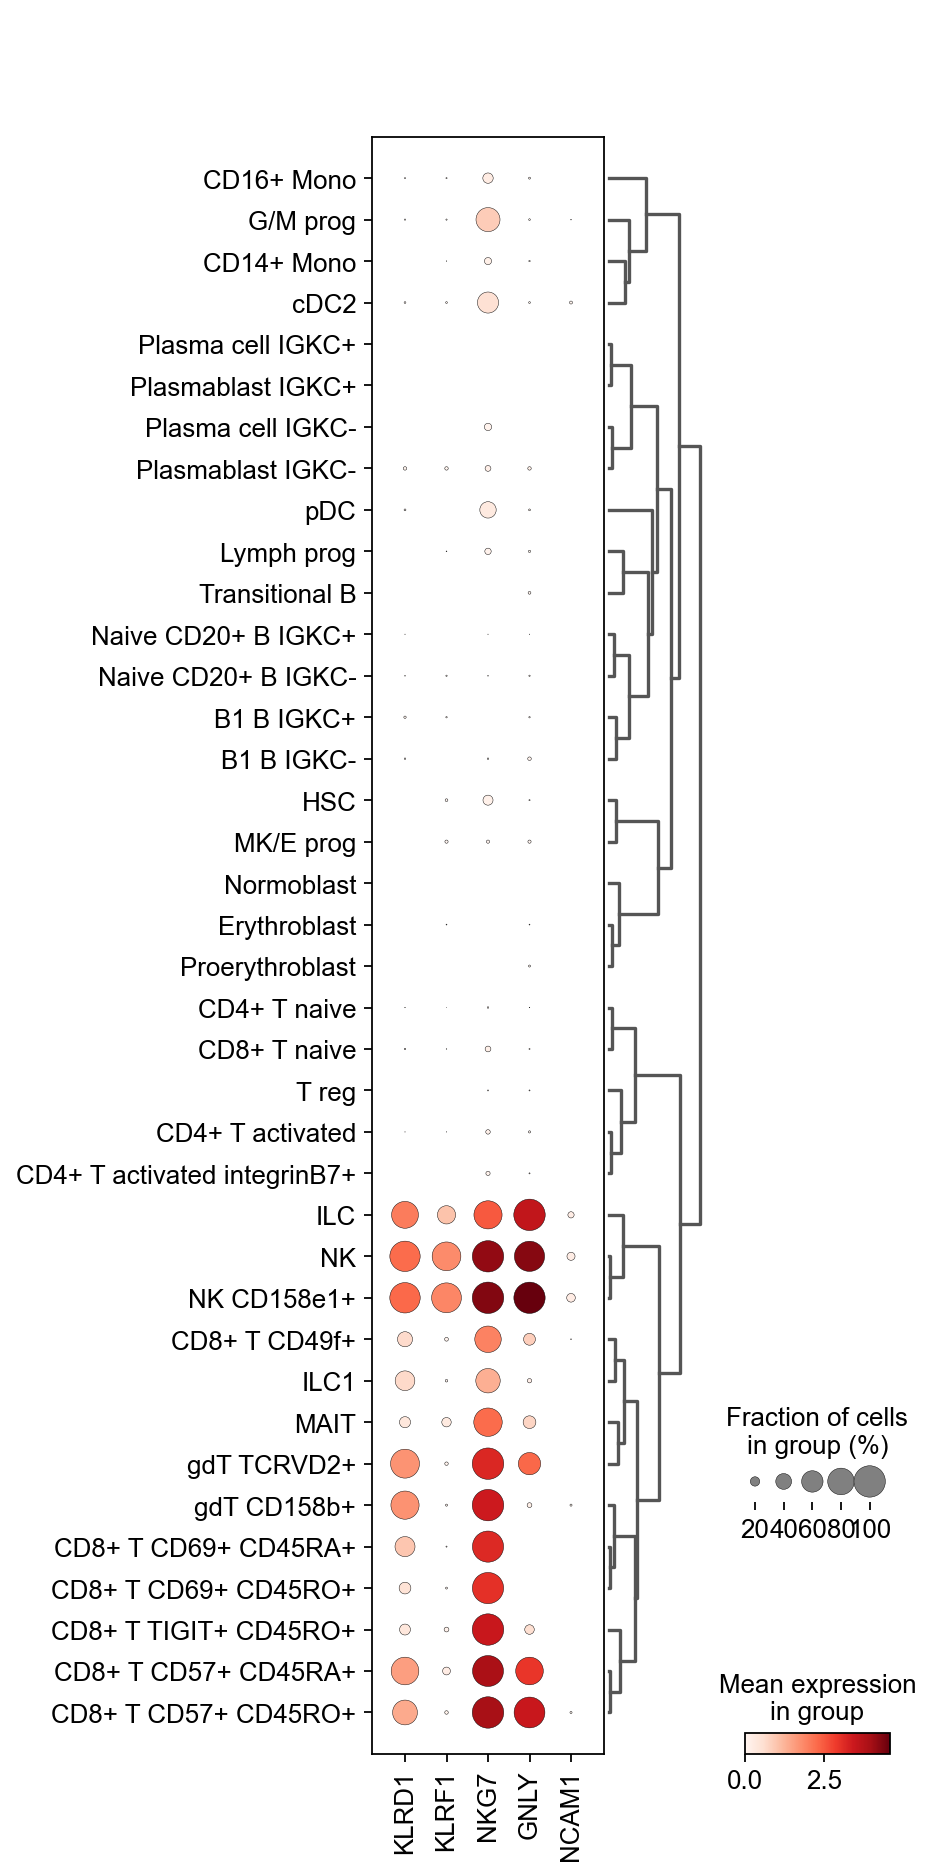

In [41]:
sc.pl.dotplot(eg, is_nk_yang, 'cell_type', dendrogram=True)

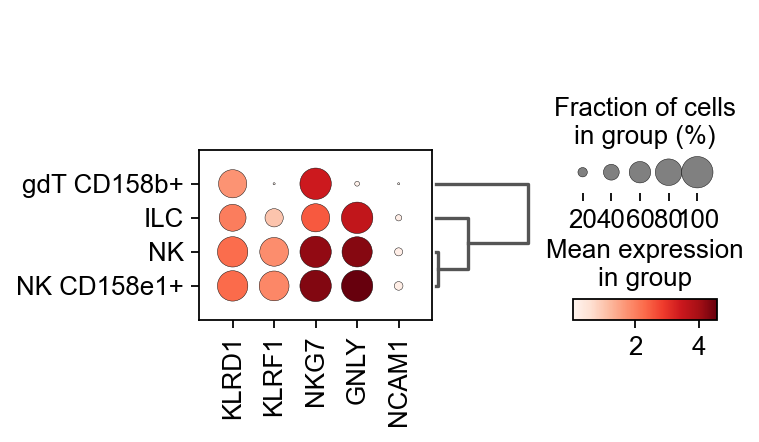

In [42]:
sc.pl.dotplot(sample_nk, is_nk_yang, 'cell_type', dendrogram=True)

## 2.1 Immature CD56bright NK cells

In [28]:
cd56bright_rna= ['IL7R', 'SELL', 'KLRC1', 'GZMK', 'CD44', 'XCL1', 'XCL2']
cd56bright_rna_low = ['FCGR3A', 'B3GAT1']

In [32]:
#calculate scores for gene sets

sc.tl.score_genes(sample_nk, cd56bright_rna, score_name = 'CD56bright_score')
sc.tl.score_genes(sample_nk, cd56bright_rna_low, score_name = 'CD56bright_low_score')

sc.tl.score_genes(eg, cd56bright_rna, score_name = 'CD56bright_score')
sc.tl.score_genes(eg, cd56bright_rna_low, score_name = 'CD56bright_low_score')

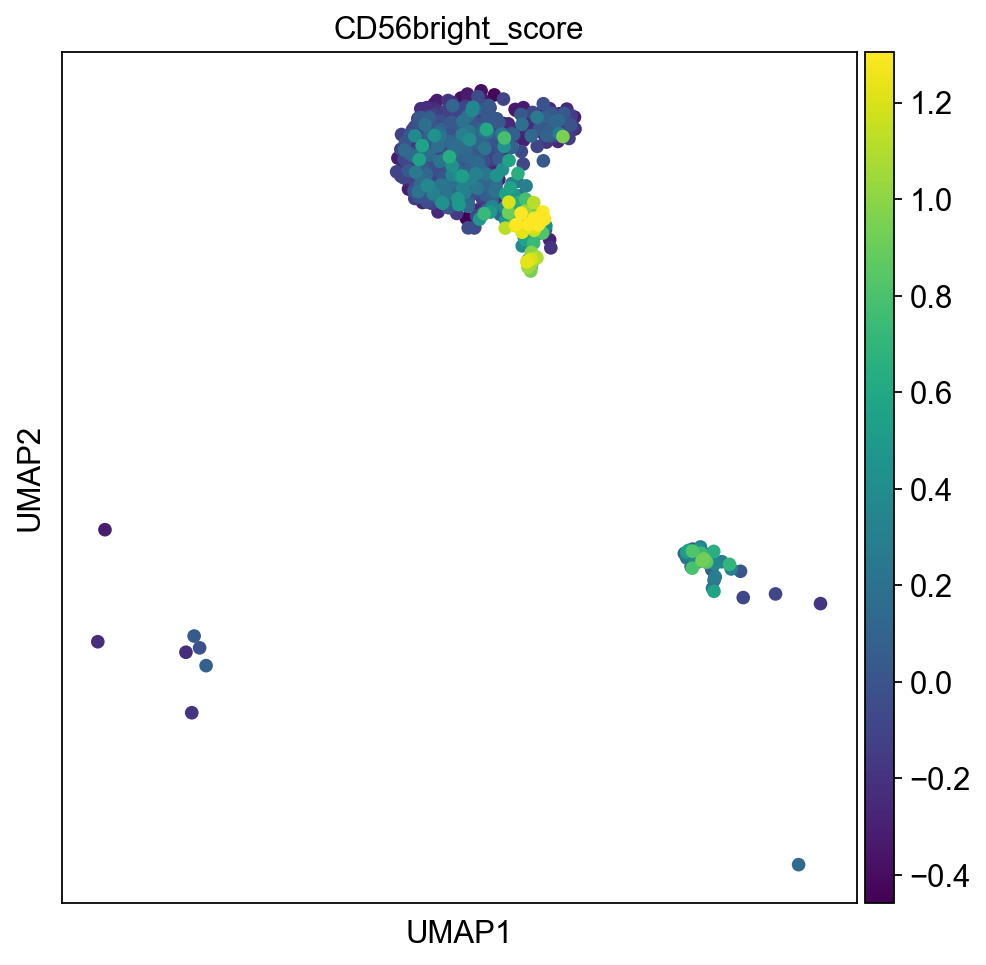

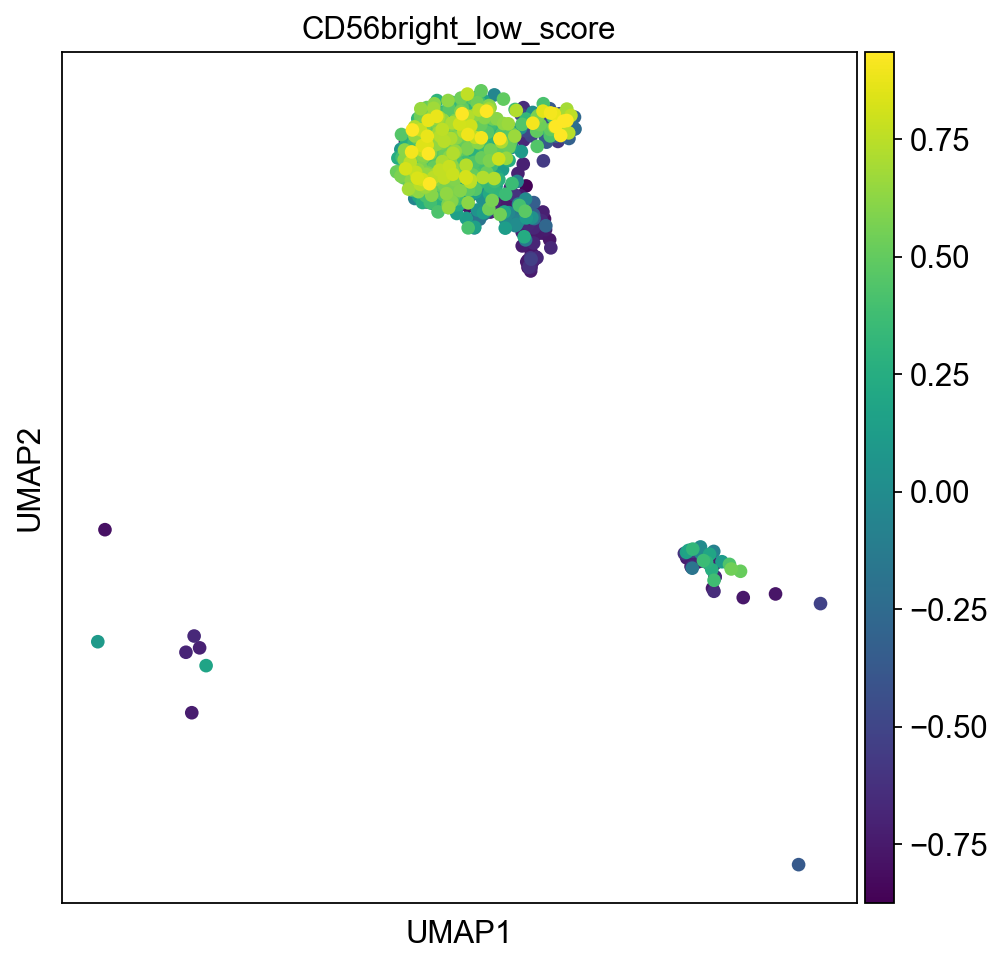

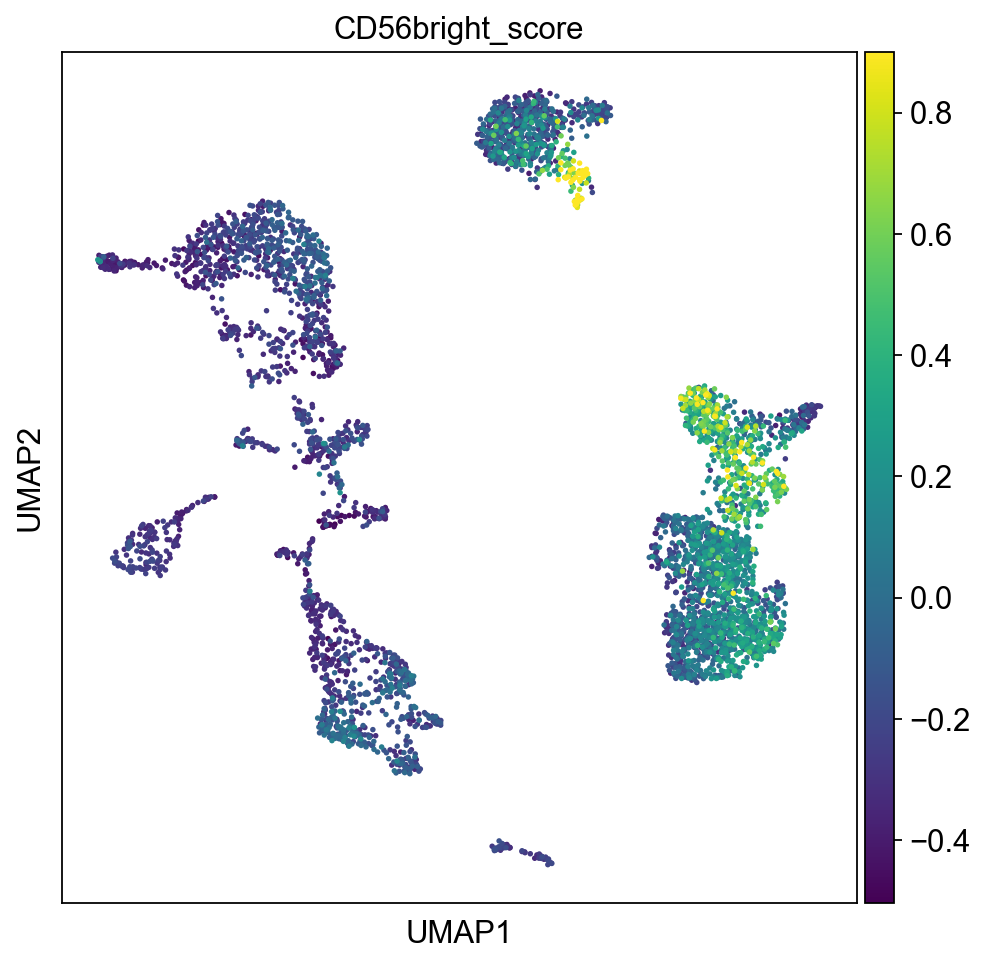

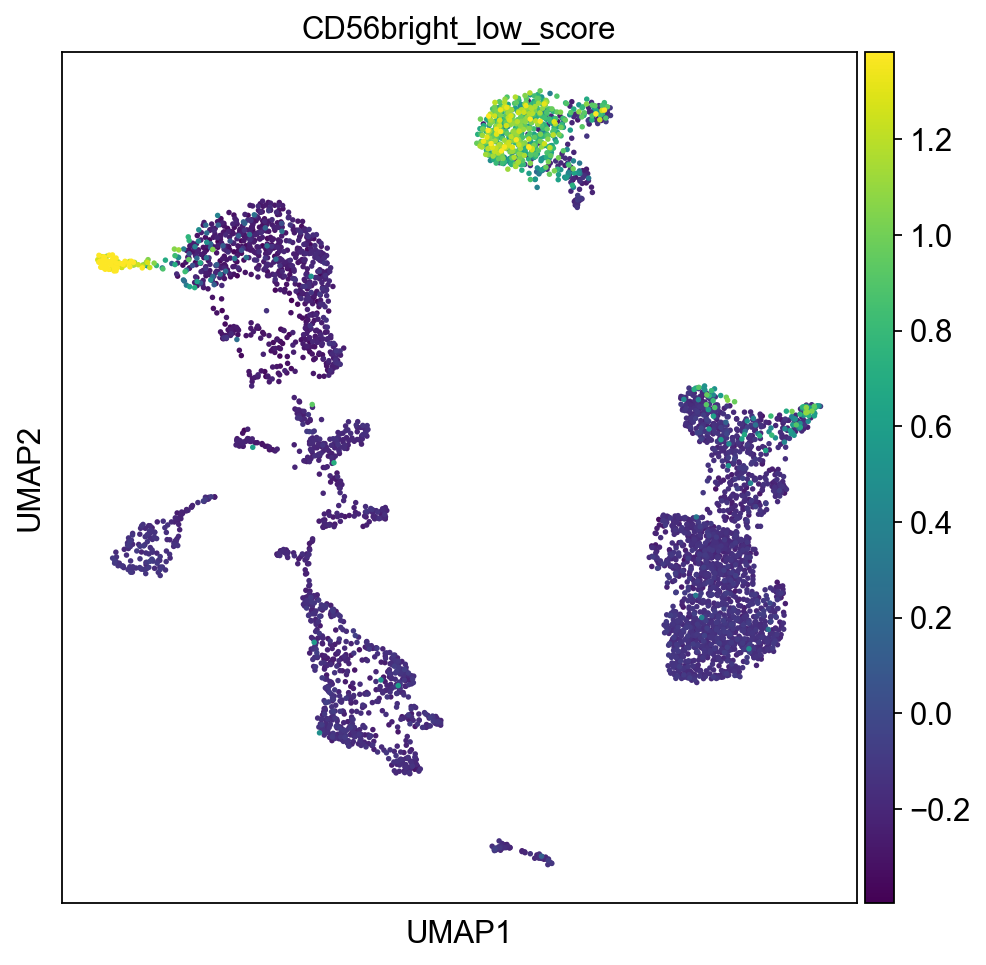

In [33]:
sc.set_figure_params(figsize=(7, 7))

sc.pl.umap(sample_nk, color = ['CD56bright_score'], vmax="p99", color_map = 'viridis', ncols=2)

sc.pl.umap(sample_nk, color = ['CD56bright_low_score'], vmax="p99", color_map = 'viridis', ncols=2)

sc.pl.umap(eg, color = ['CD56bright_score'], vmax="p99", color_map = 'viridis', ncols=2)

sc.pl.umap(eg, color = ['CD56bright_low_score'], vmax="p99", color_map = 'viridis', ncols=2)



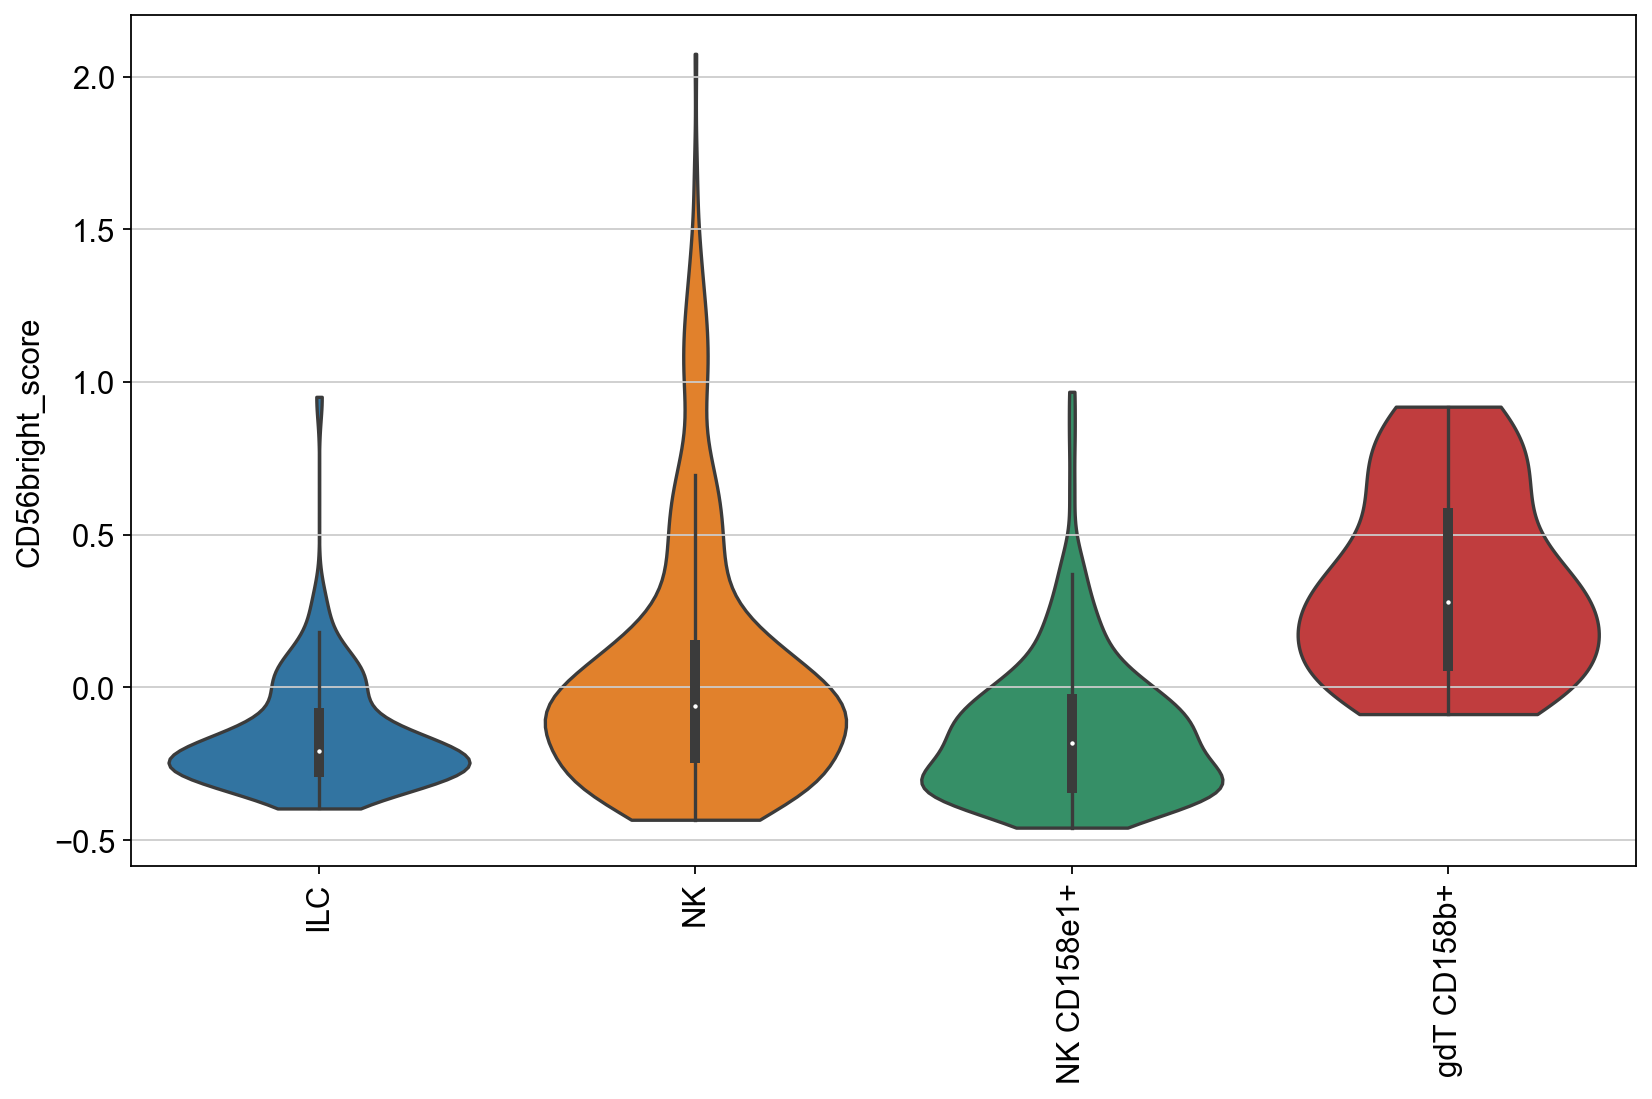

In [35]:
sc.set_figure_params(figsize=(10, 7))

sc.pl.violin(sample_nk, ['CD56bright_score'], groupby='cell_type', stripplot=False, inner='box', rotation=90)  


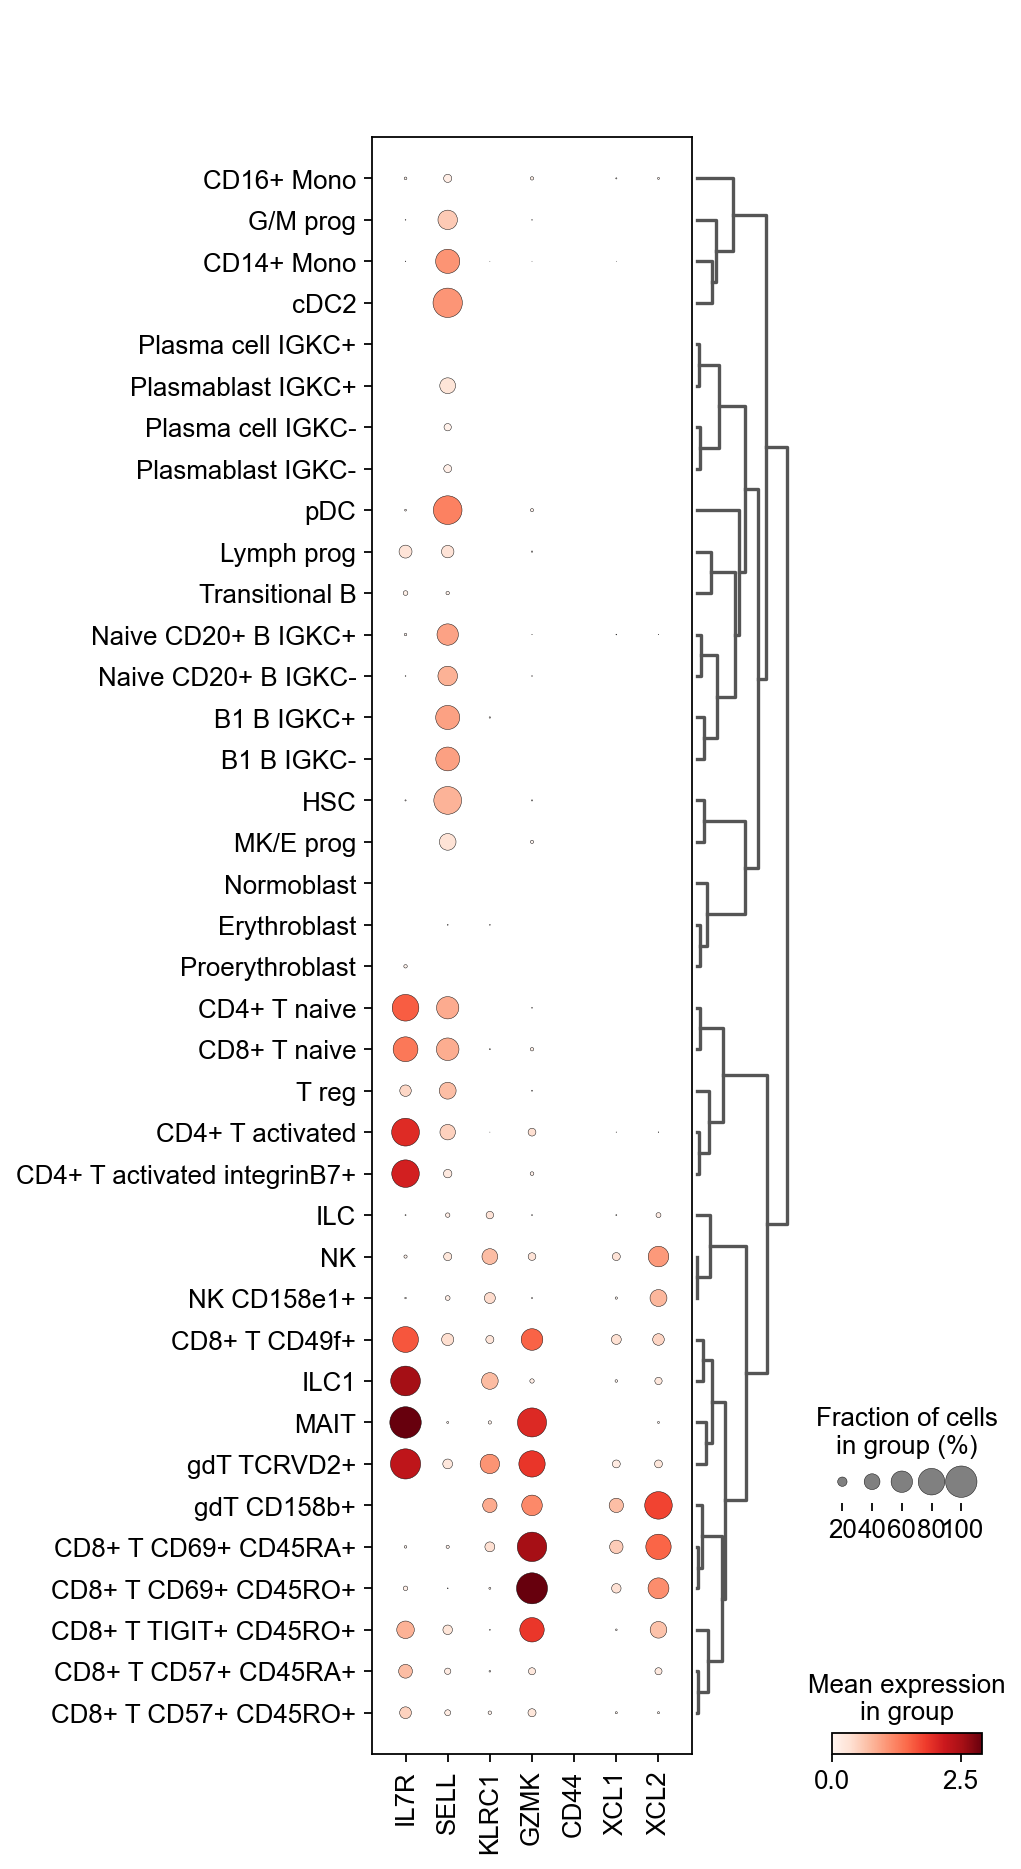

In [36]:
sc.pl.dotplot(eg, cd56bright_rna, 'cell_type', dendrogram=True)

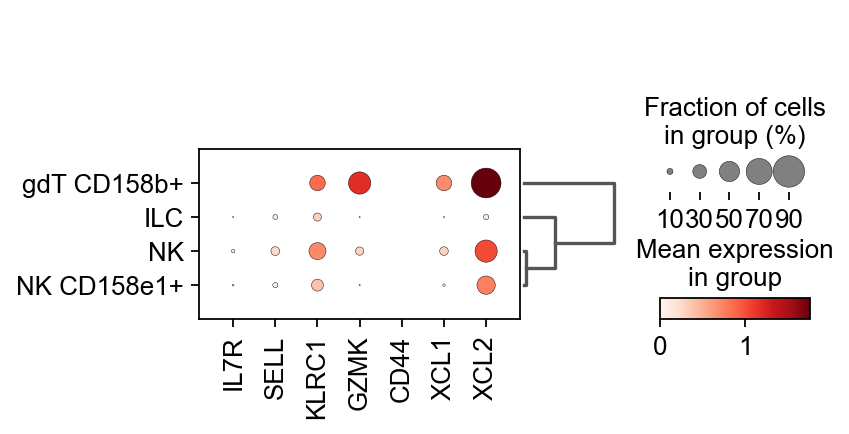

In [37]:
sc.pl.dotplot(sample_nk, cd56bright_rna, 'cell_type', dendrogram=True)

## 2.2 Transitional NK

Defined by down-regulation of the genes of CD56bright cluster and uppregulation of the genes of CD56dim cluster. 


## 2.3 Adaptive NK

In [35]:
adaptive_high_rna = ['KLRC2', 'CD52', 'CD3E', 'CD3D', 'CD3G', 'IL32' ]
adaptive_low_rna = ['FCER1G', 'SYK', 'SH2D1B', 'ZBTB16']


In [36]:
#calculating gene scores
sc.tl.score_genes(eg, adaptive_high_rna, score_name = 'adaptive_high_score')
sc.tl.score_genes(eg, adaptive_low_rna, score_name = 'adaptive_low_score')


In [37]:
#calculating gene scores
sc.tl.score_genes(sample_nk, adaptive_high_rna, score_name = 'adaptive_high_score')
sc.tl.score_genes(sample_nk, adaptive_low_rna, score_name = 'adaptive_low_score')

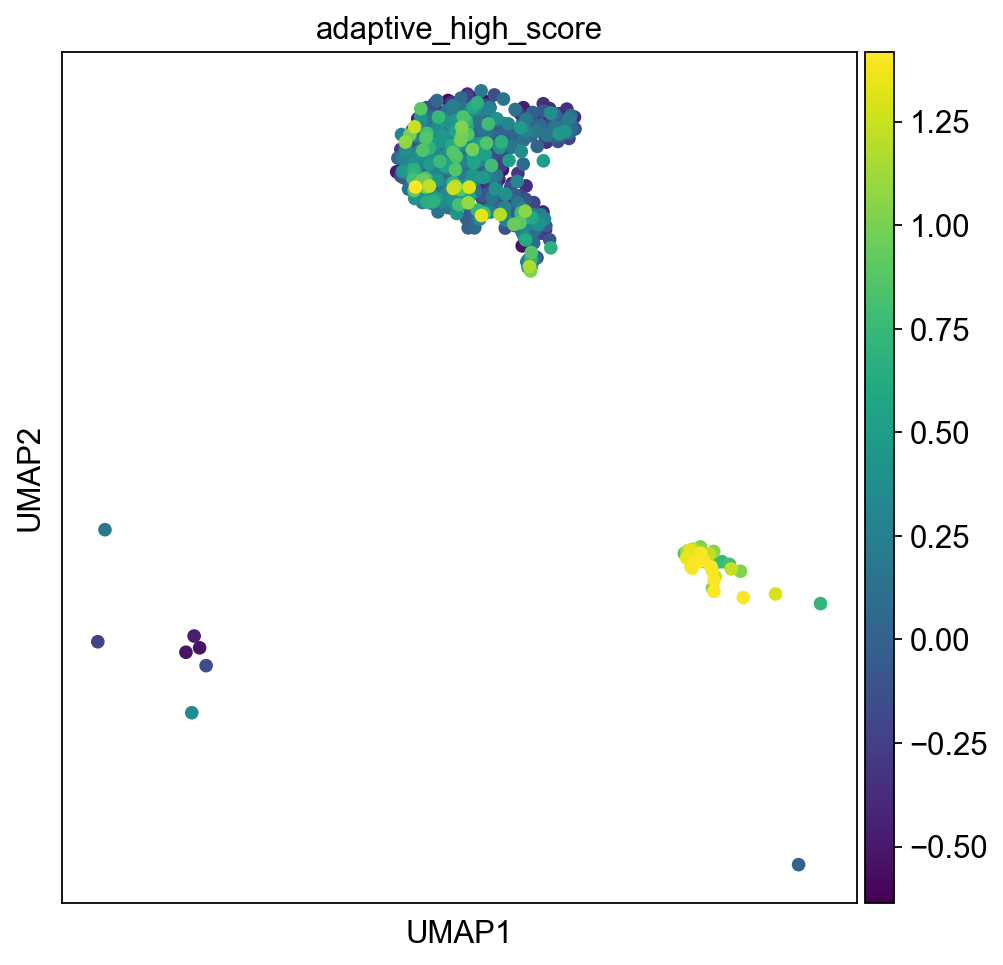

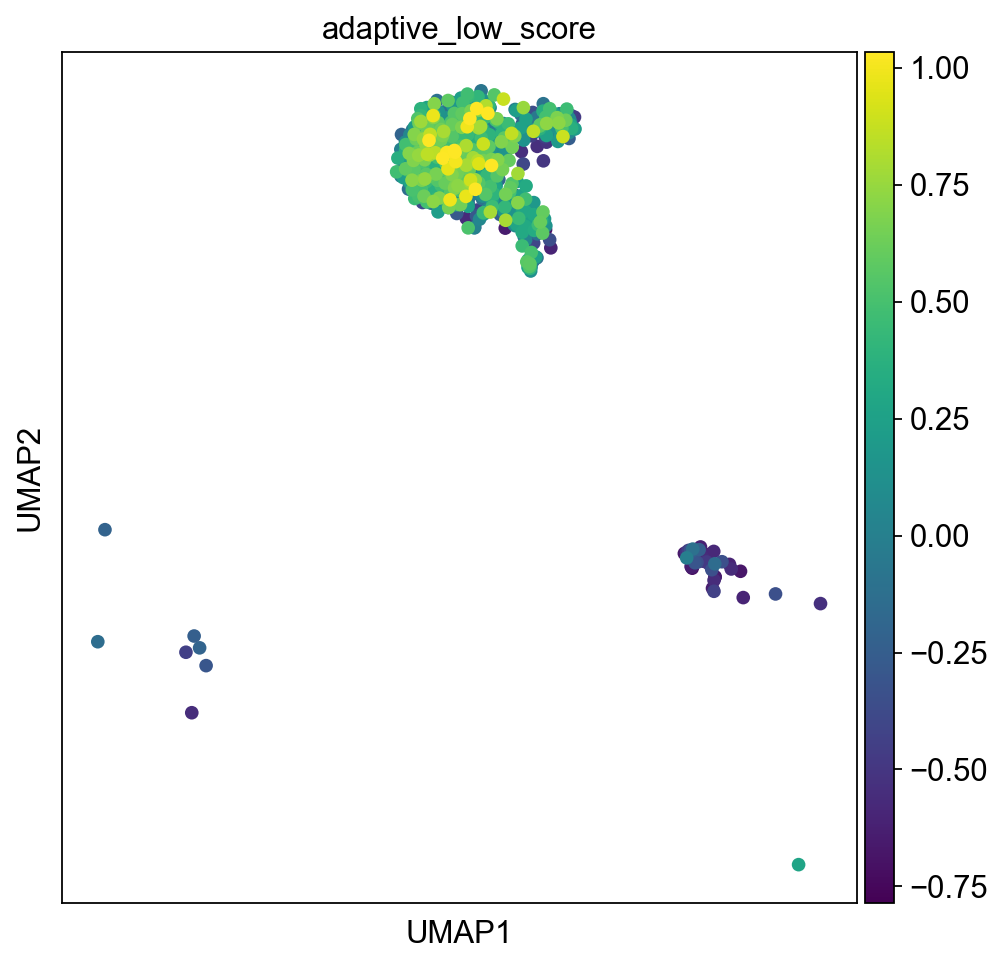

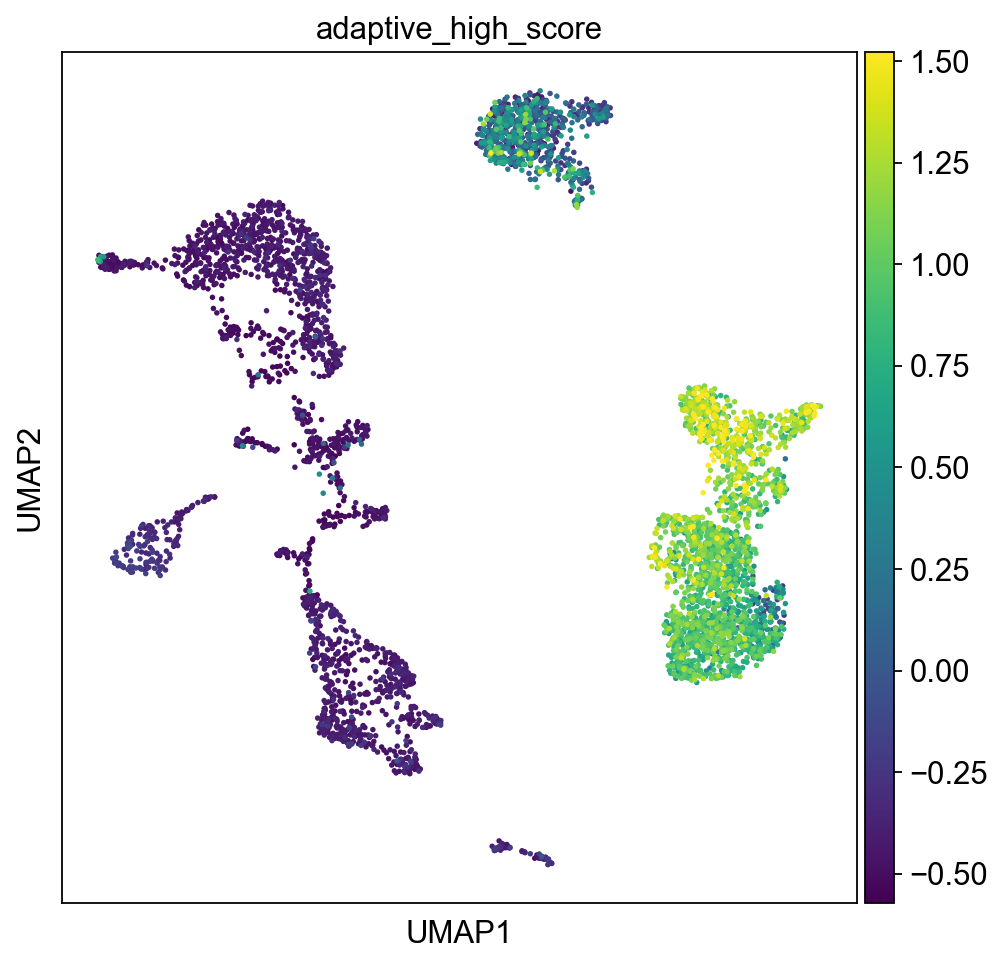

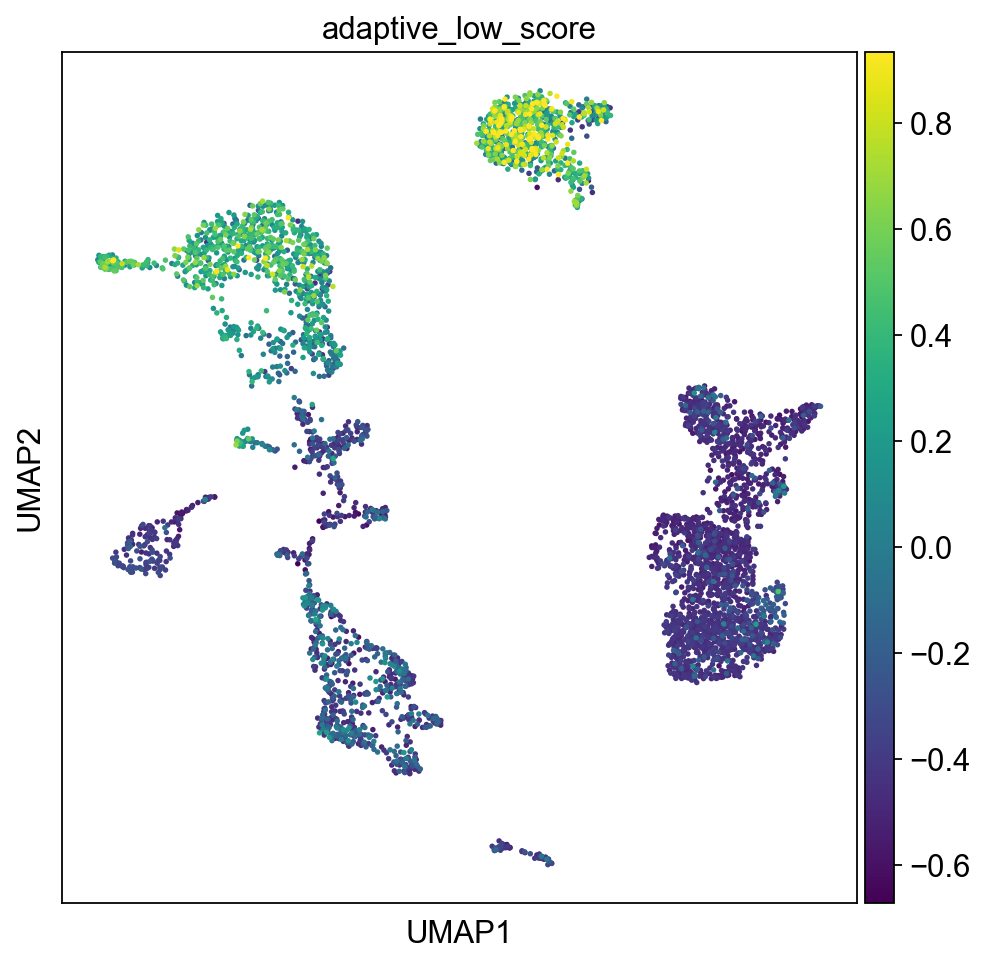

In [38]:
sc.set_figure_params(figsize=(7, 7))

sc.pl.umap(sample_nk, color = ['adaptive_high_score'], vmax="p99", color_map = 'viridis', ncols=2)

sc.pl.umap(sample_nk, color = ['adaptive_low_score'], vmax="p99", color_map = 'viridis', ncols=2)

sc.pl.umap(eg, color = ['adaptive_high_score'], vmax="p99", color_map = 'viridis', ncols=2)

sc.pl.umap(eg, color = ['adaptive_low_score'], vmax="p99", color_map = 'viridis', ncols=2)


Highly expressed in adaptive NK cells


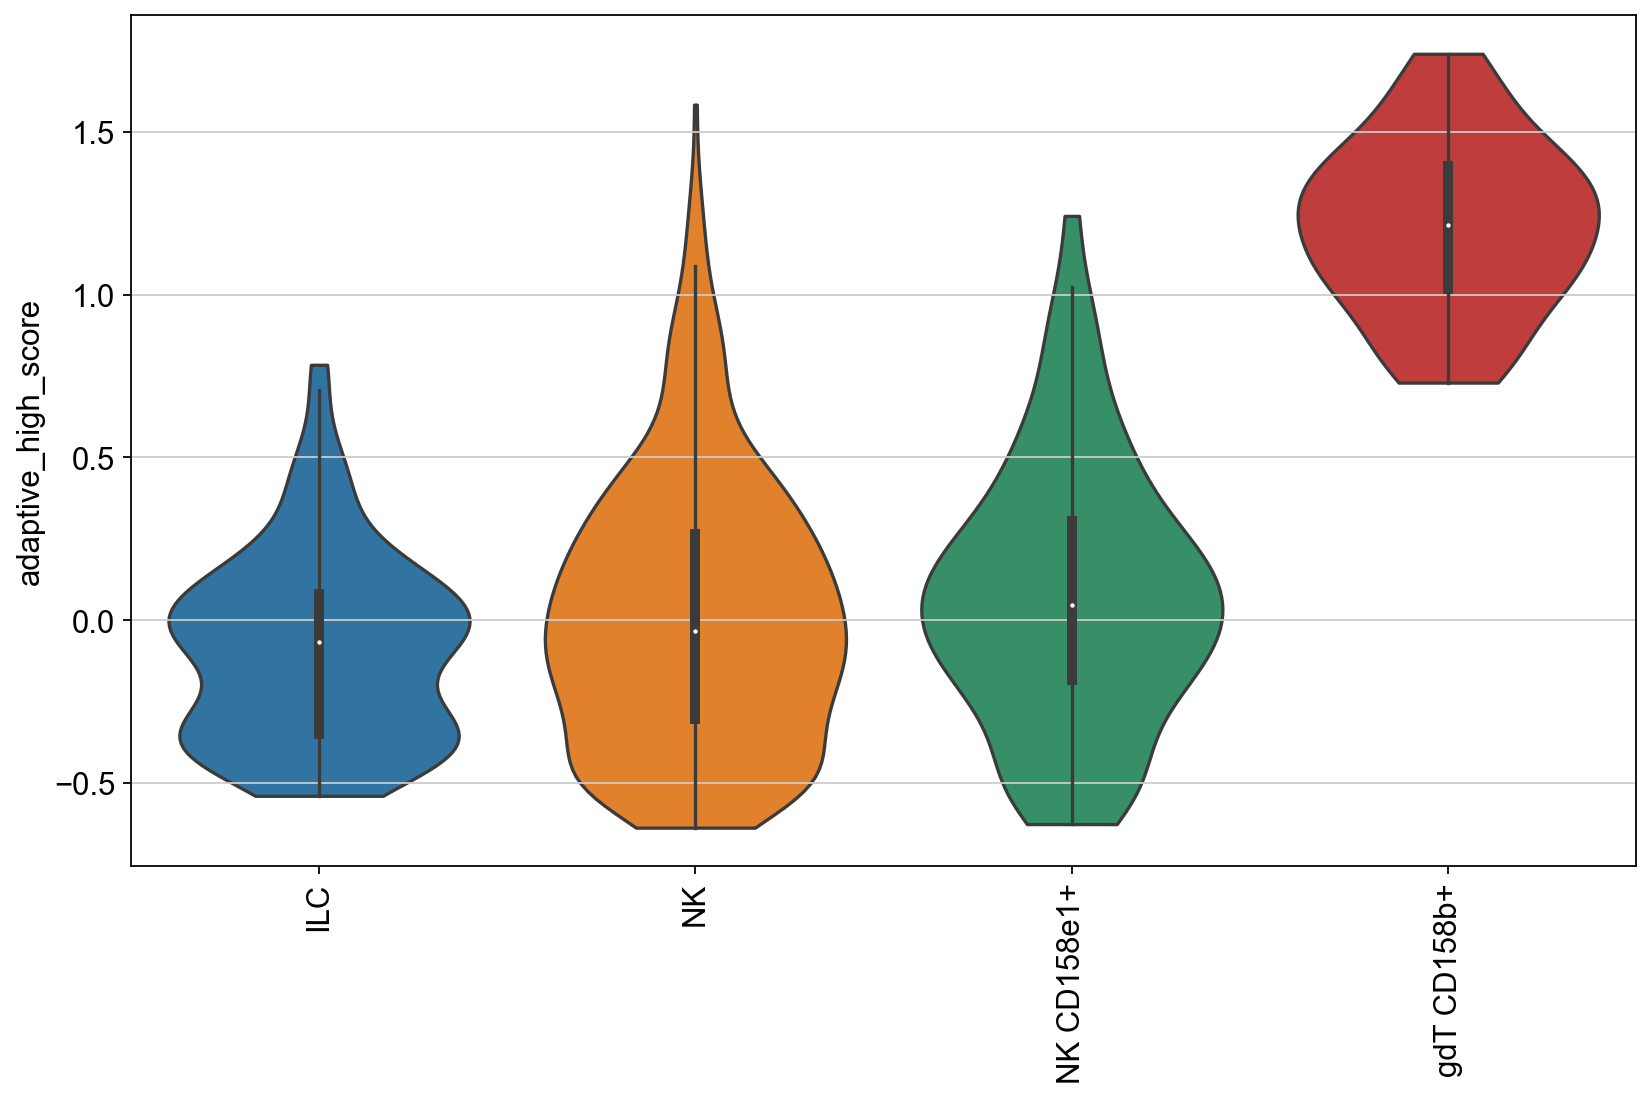

Lower expression in adaptive NK cells


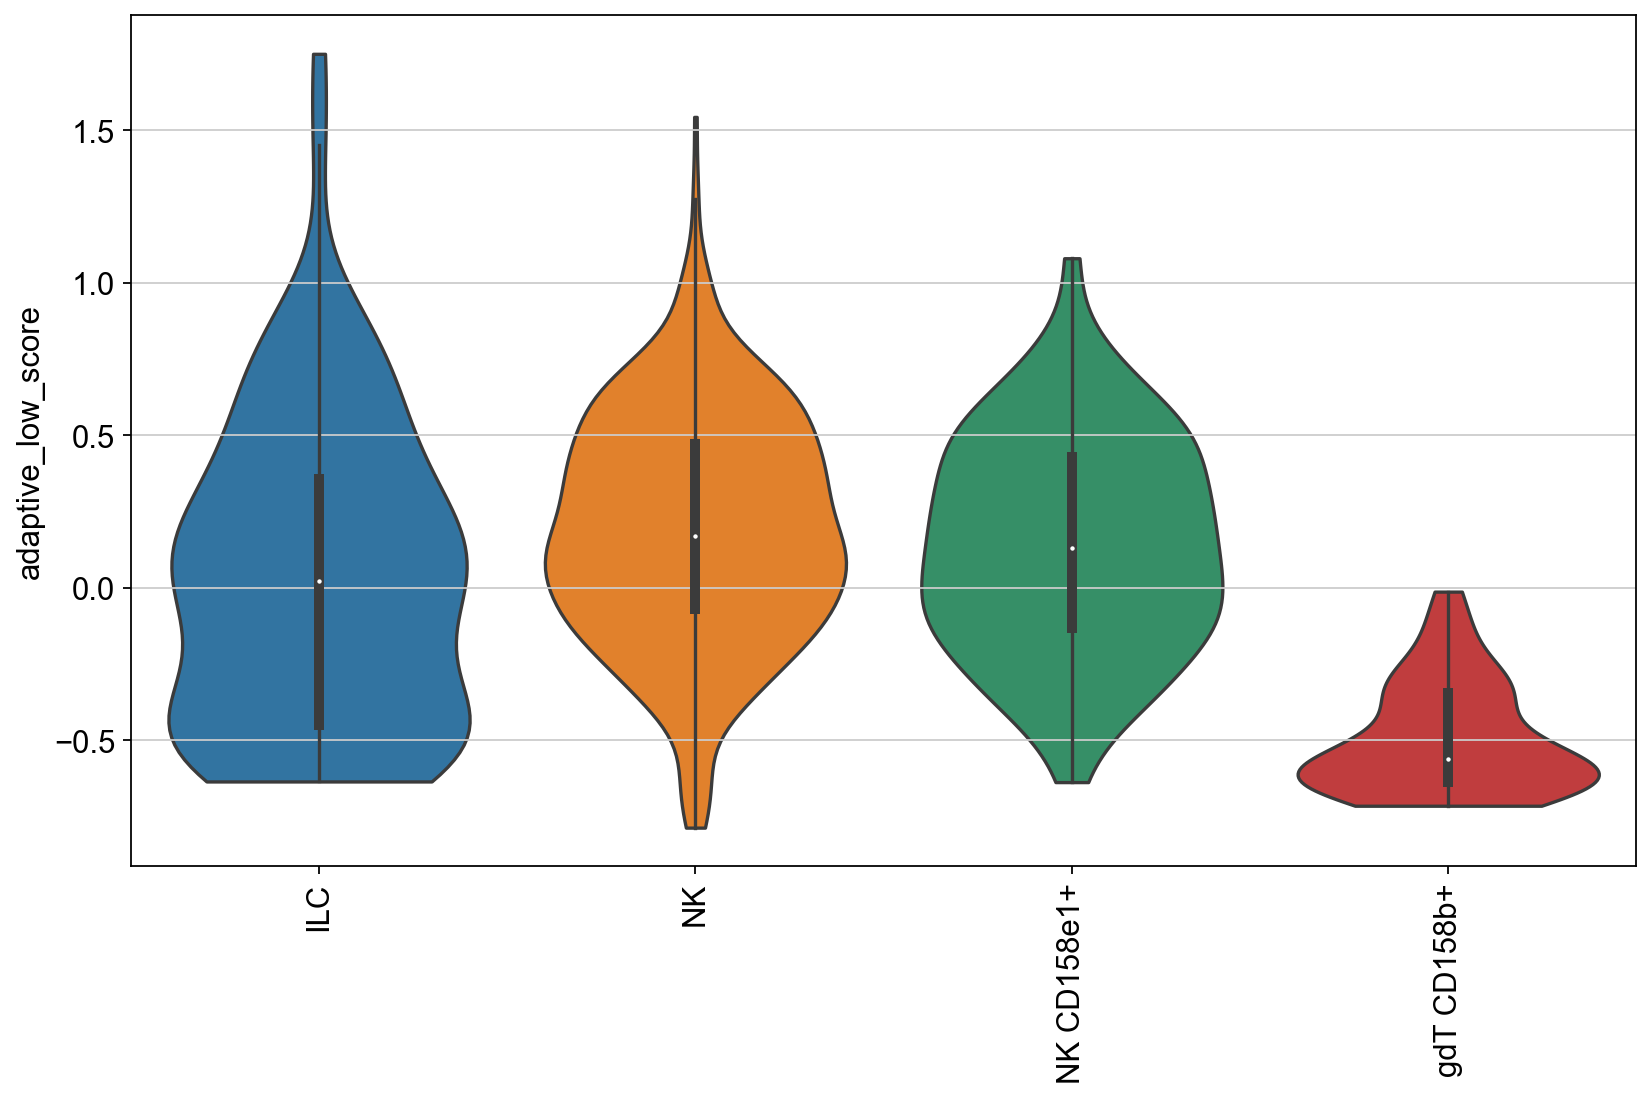

In [45]:
sc.set_figure_params(figsize=(10, 7))

print("Highly expressed in adaptive NK cells")
sc.pl.violin(sample_nk, ['adaptive_high_score'], groupby='cell_type', stripplot=False, inner='box', rotation=90)  

print("Lower expression in adaptive NK cells")
sc.pl.violin(sample_nk, ['adaptive_low_score'], groupby='cell_type', stripplot=False, inner='box', rotation=90)  



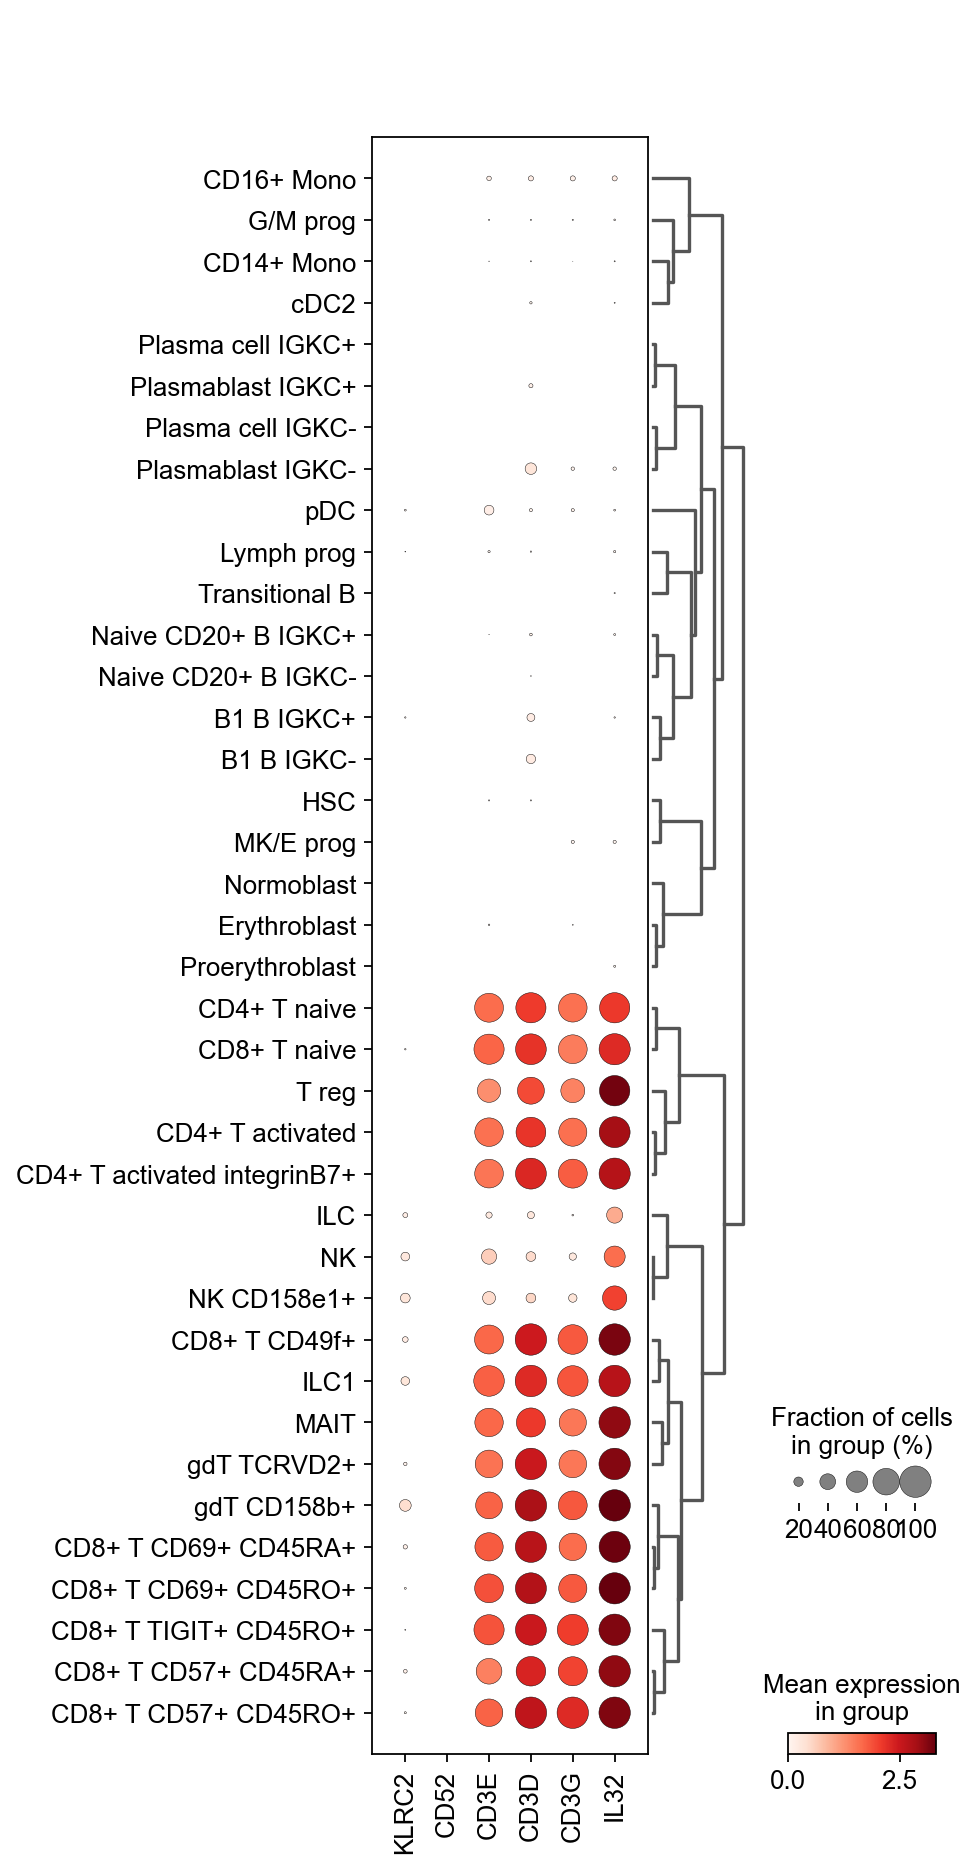

In [46]:
sc.pl.dotplot(eg, adaptive_high_rna, 'cell_type', dendrogram=True)

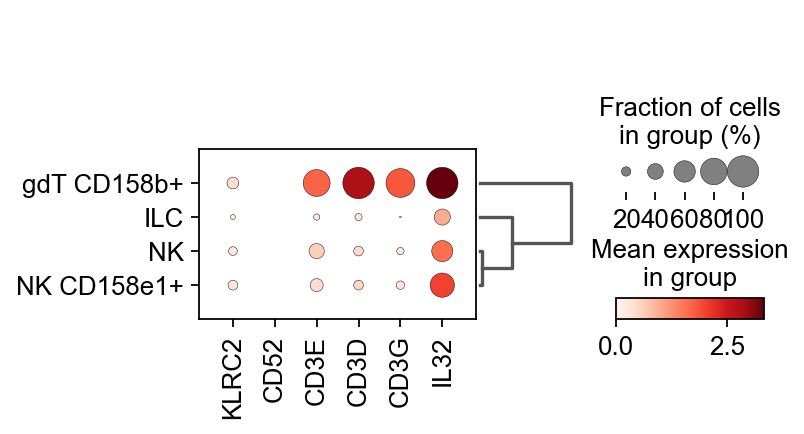

In [47]:
sc.pl.dotplot(sample_nk, adaptive_high_rna, 'cell_type', dendrogram=True)

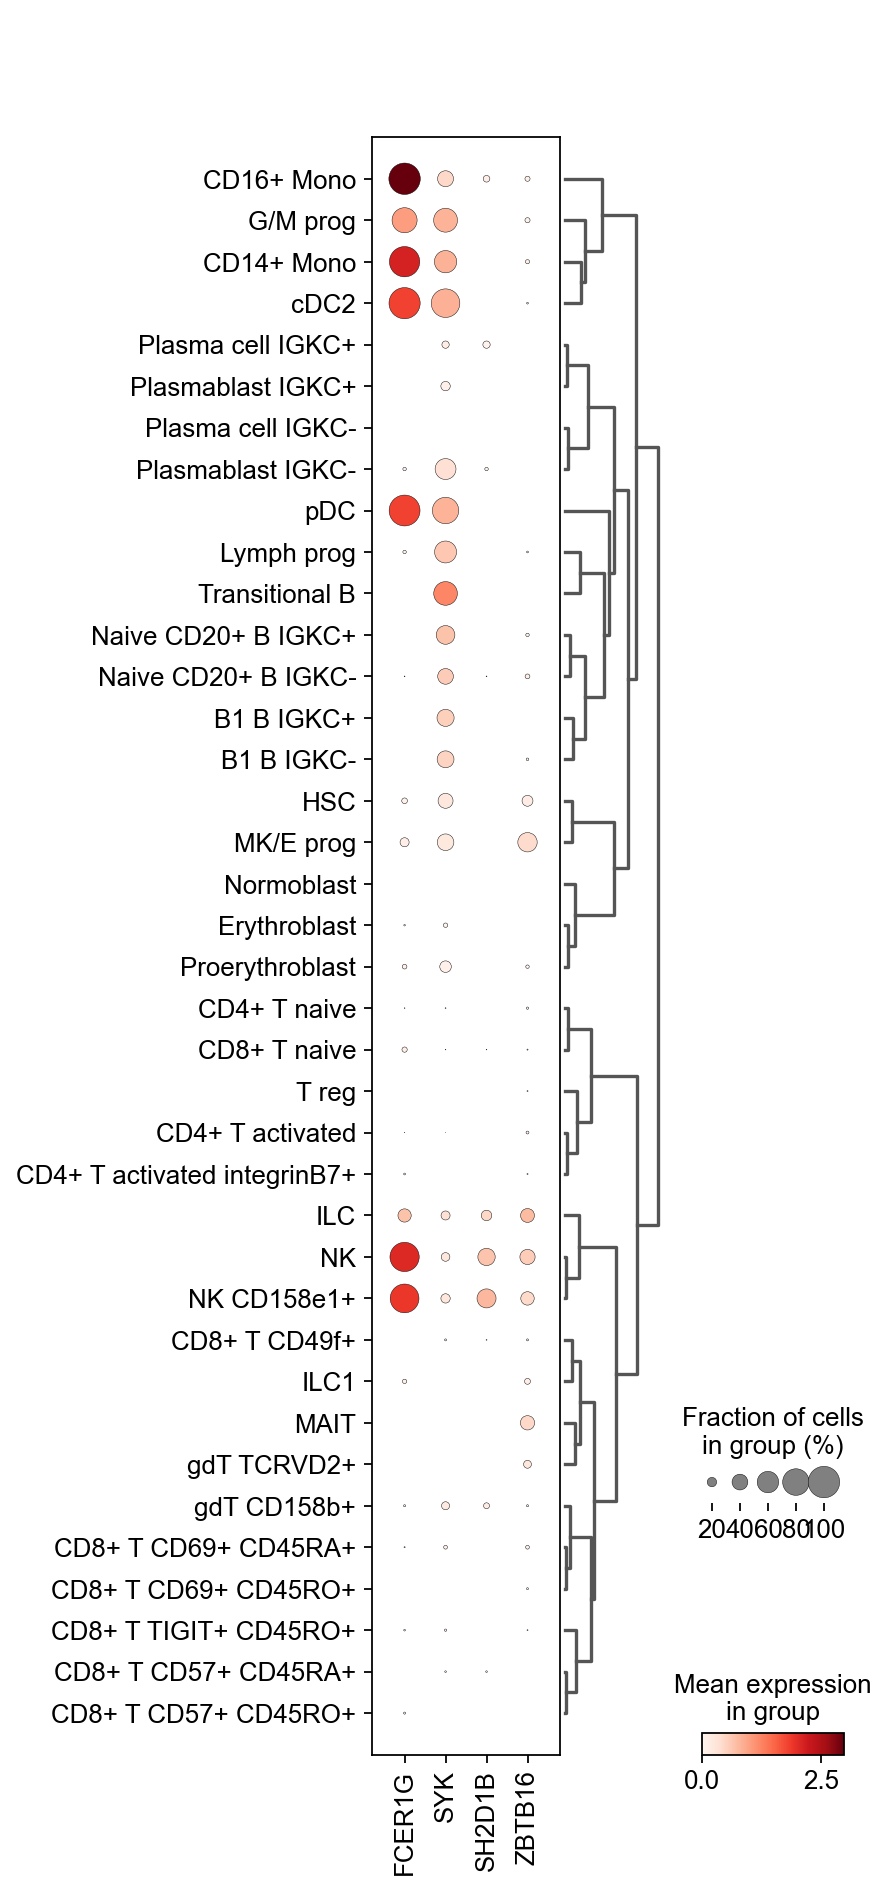

In [48]:
sc.pl.dotplot(eg, adaptive_low_rna, 'cell_type', dendrogram=True)

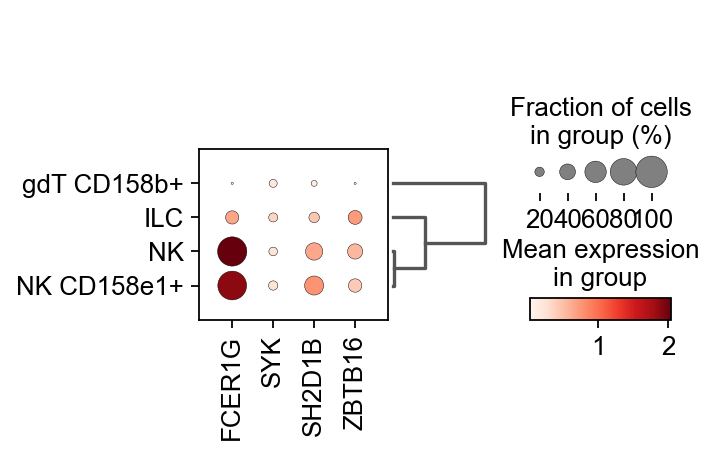

In [49]:
sc.pl.dotplot(sample_nk, adaptive_low_rna, 'cell_type', dendrogram=True)

## 2.4 Mature NK

In [40]:
mature_rna= ['B3GAT1', 'PRF1', 'GZMA', 'GZMB', 'GZMH', 'ACTB', 'ARPC2', 'CORO1A', 'CFL1', 'CST7', 'PFN1', 'ANXA1']


In [41]:
#Calculating gene scores
sc.tl.score_genes(eg, mature_rna, score_name = 'mature_score')
sc.tl.score_genes(sample_nk, mature_rna, score_name = 'mature_score')

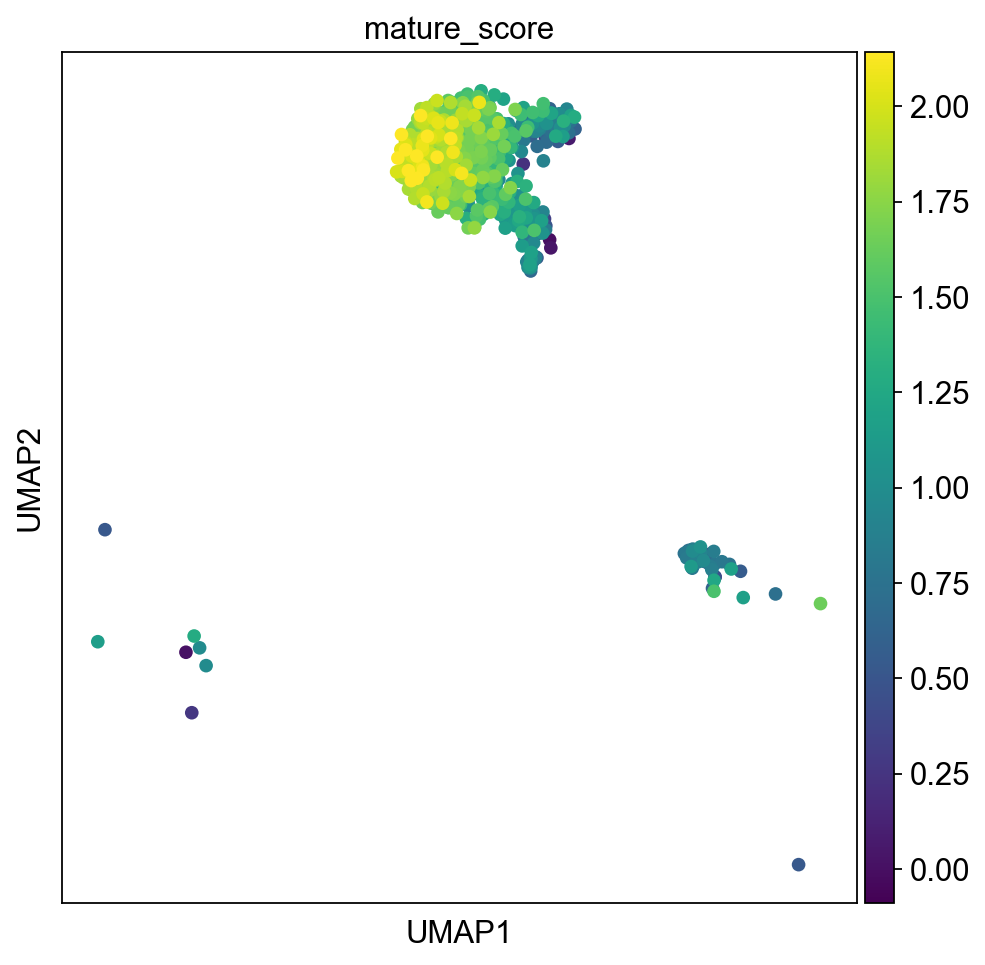

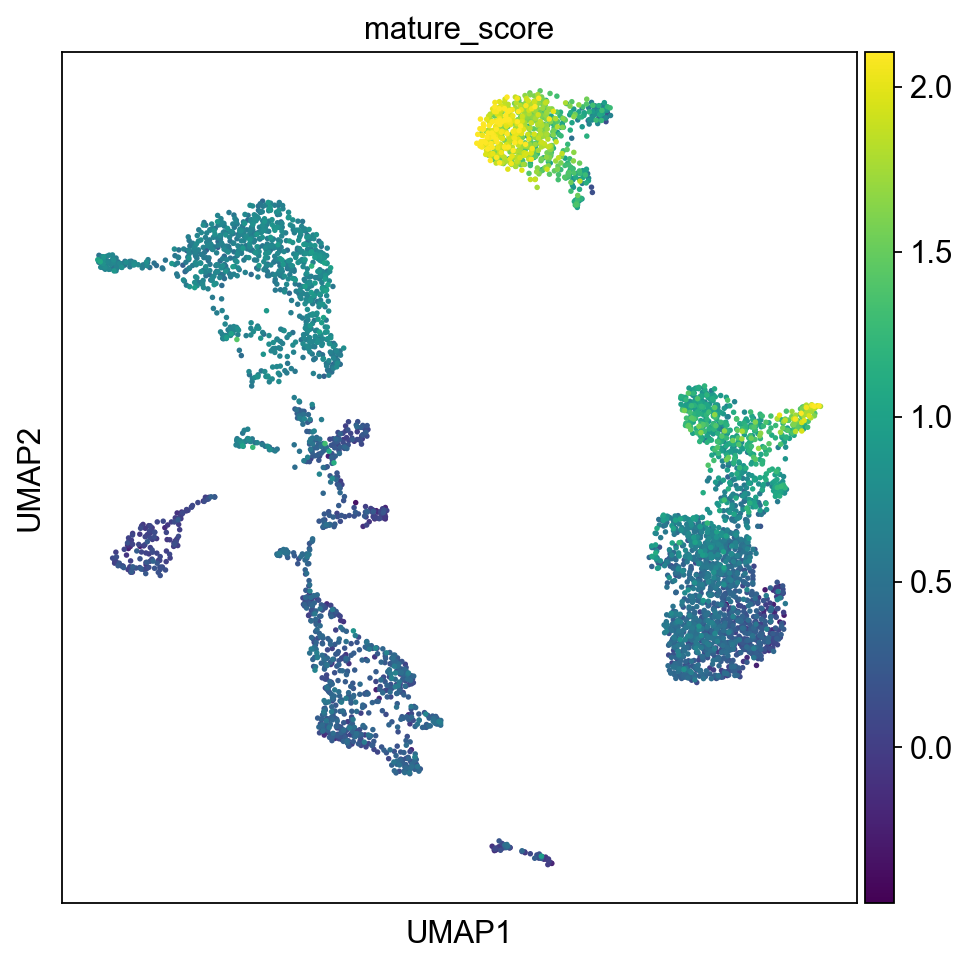

In [42]:
sc.set_figure_params(figsize=(7, 7))

sc.pl.umap(sample_nk, color = ['mature_score'], vmax="p99", color_map = 'viridis', ncols=2)
sc.pl.umap(eg, color = ['mature_score'], vmax="p99", color_map = 'viridis', ncols=2)



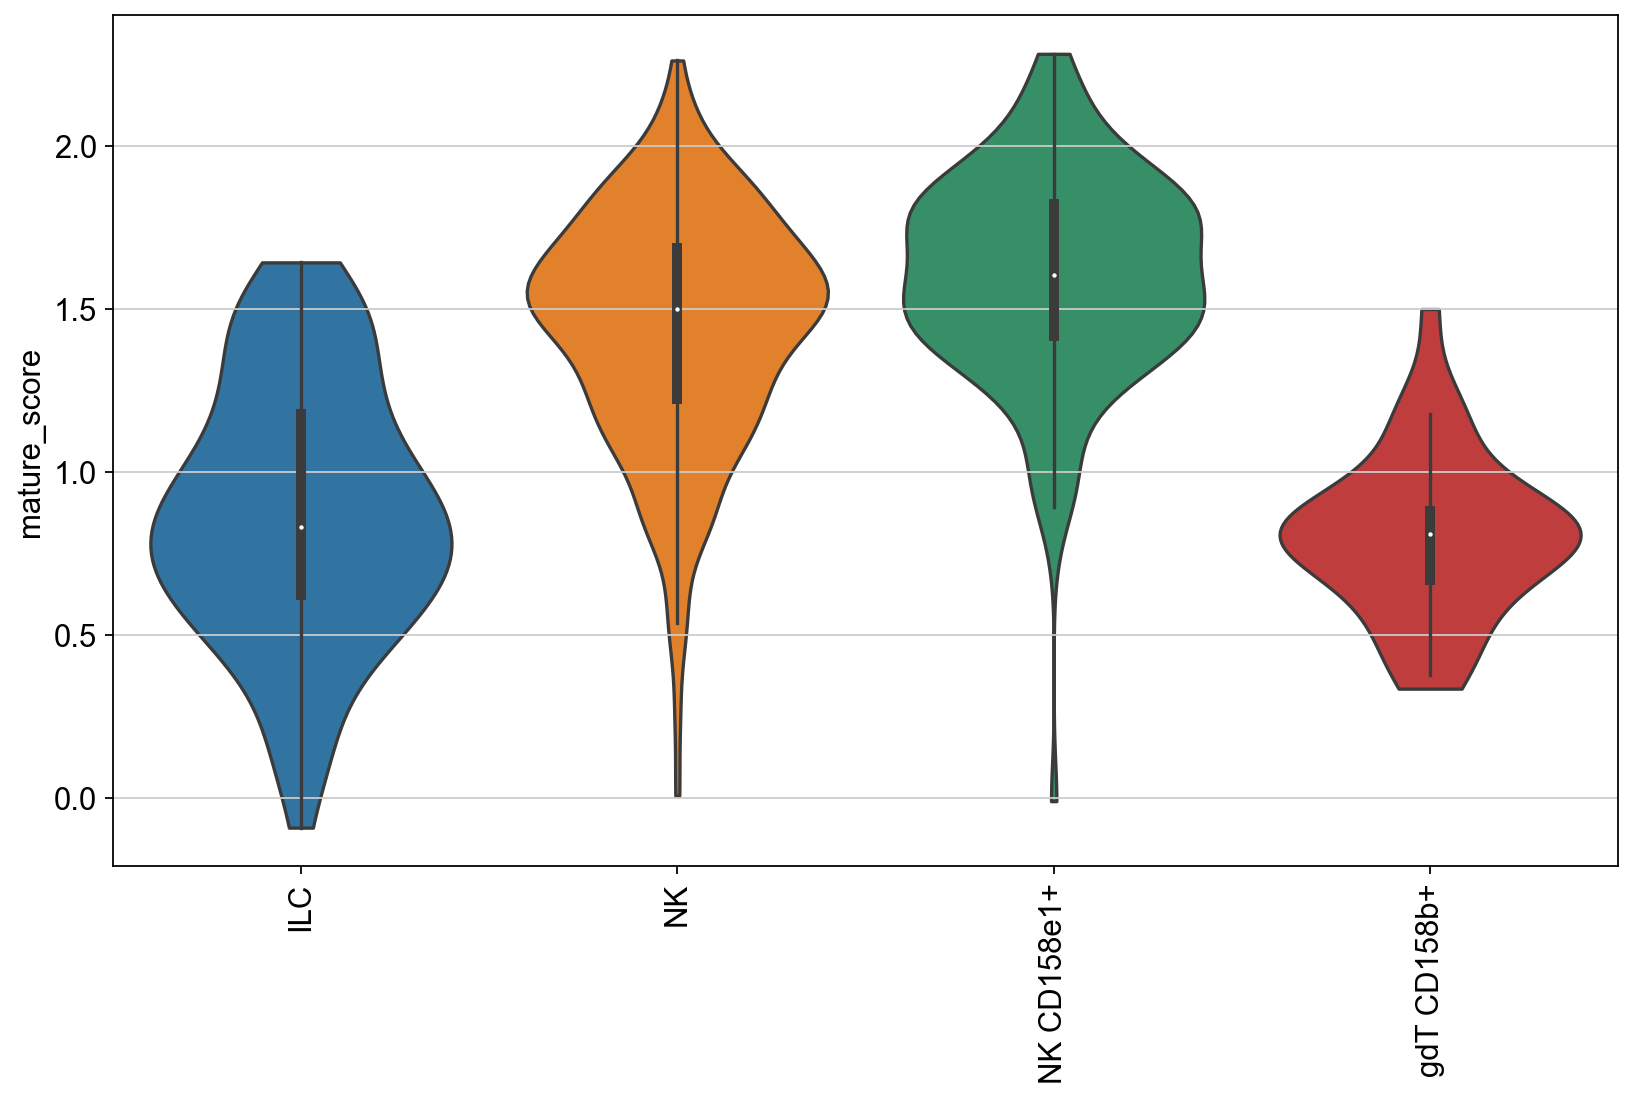

In [50]:
sc.set_figure_params(figsize=(10, 7))

sc.pl.violin(sample_nk, ['mature_score'], groupby='cell_type', stripplot=False, inner='box', rotation=90)  

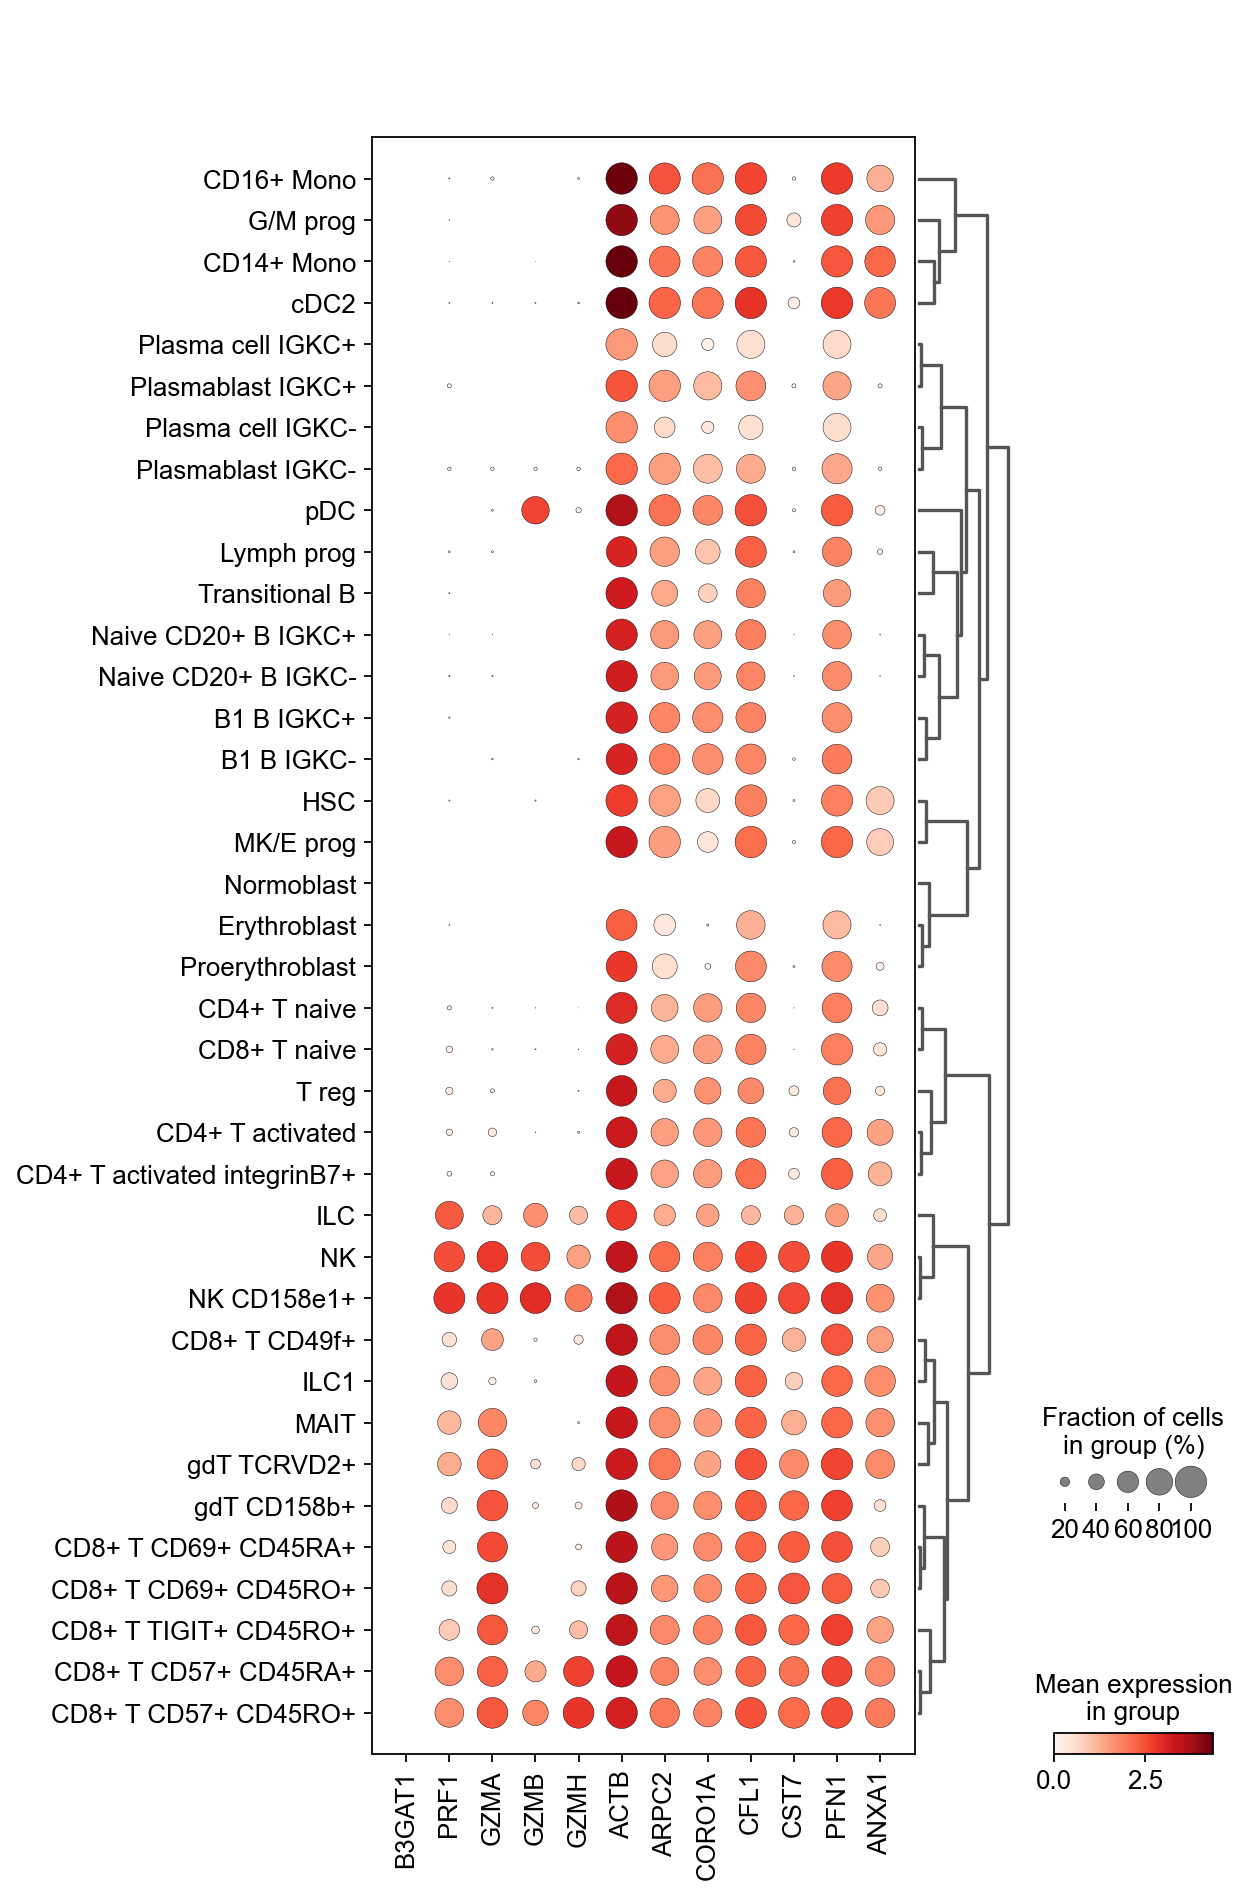

In [51]:
sc.pl.dotplot(eg, mature_rna, 'cell_type', dendrogram=True)

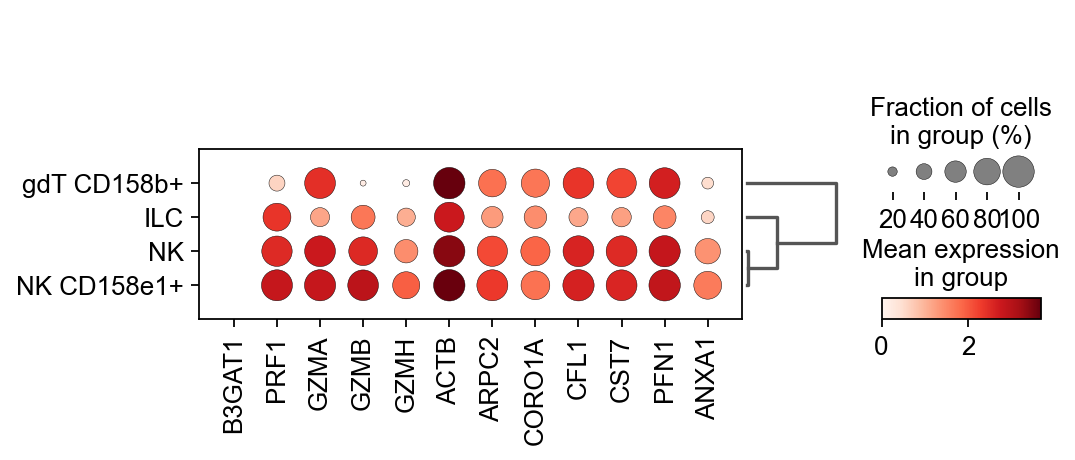

In [52]:
sc.pl.dotplot(sample_nk, mature_rna, 'cell_type', dendrogram=True)

## 2.5 Terminal NK cells 

In [29]:
terminal_rna_bm = ['ZEB2',  'CX3CR1','HAVCR2','WDR74', 'SNORD3A', 'TMEM107', 'SNORD3D', 'RNU12', 'SNORD3B-2', 'SNORD3B-1', 'C12orf57', 'HIST1H1E', 'HIST1H1C', 'HIST1H1D', 'HIST2H2BE', 'RNU11', 'JUN', 'PTCH2', 'RP11-386I14.4','CD38']

In [30]:
#calculating gene scores (only bm markers)

sc.tl.score_genes(eg, terminal_rna_bm, score_name = 'terminal_score')
sc.tl.score_genes(sample_nk, terminal_rna_bm, score_name = 'terminal_score')


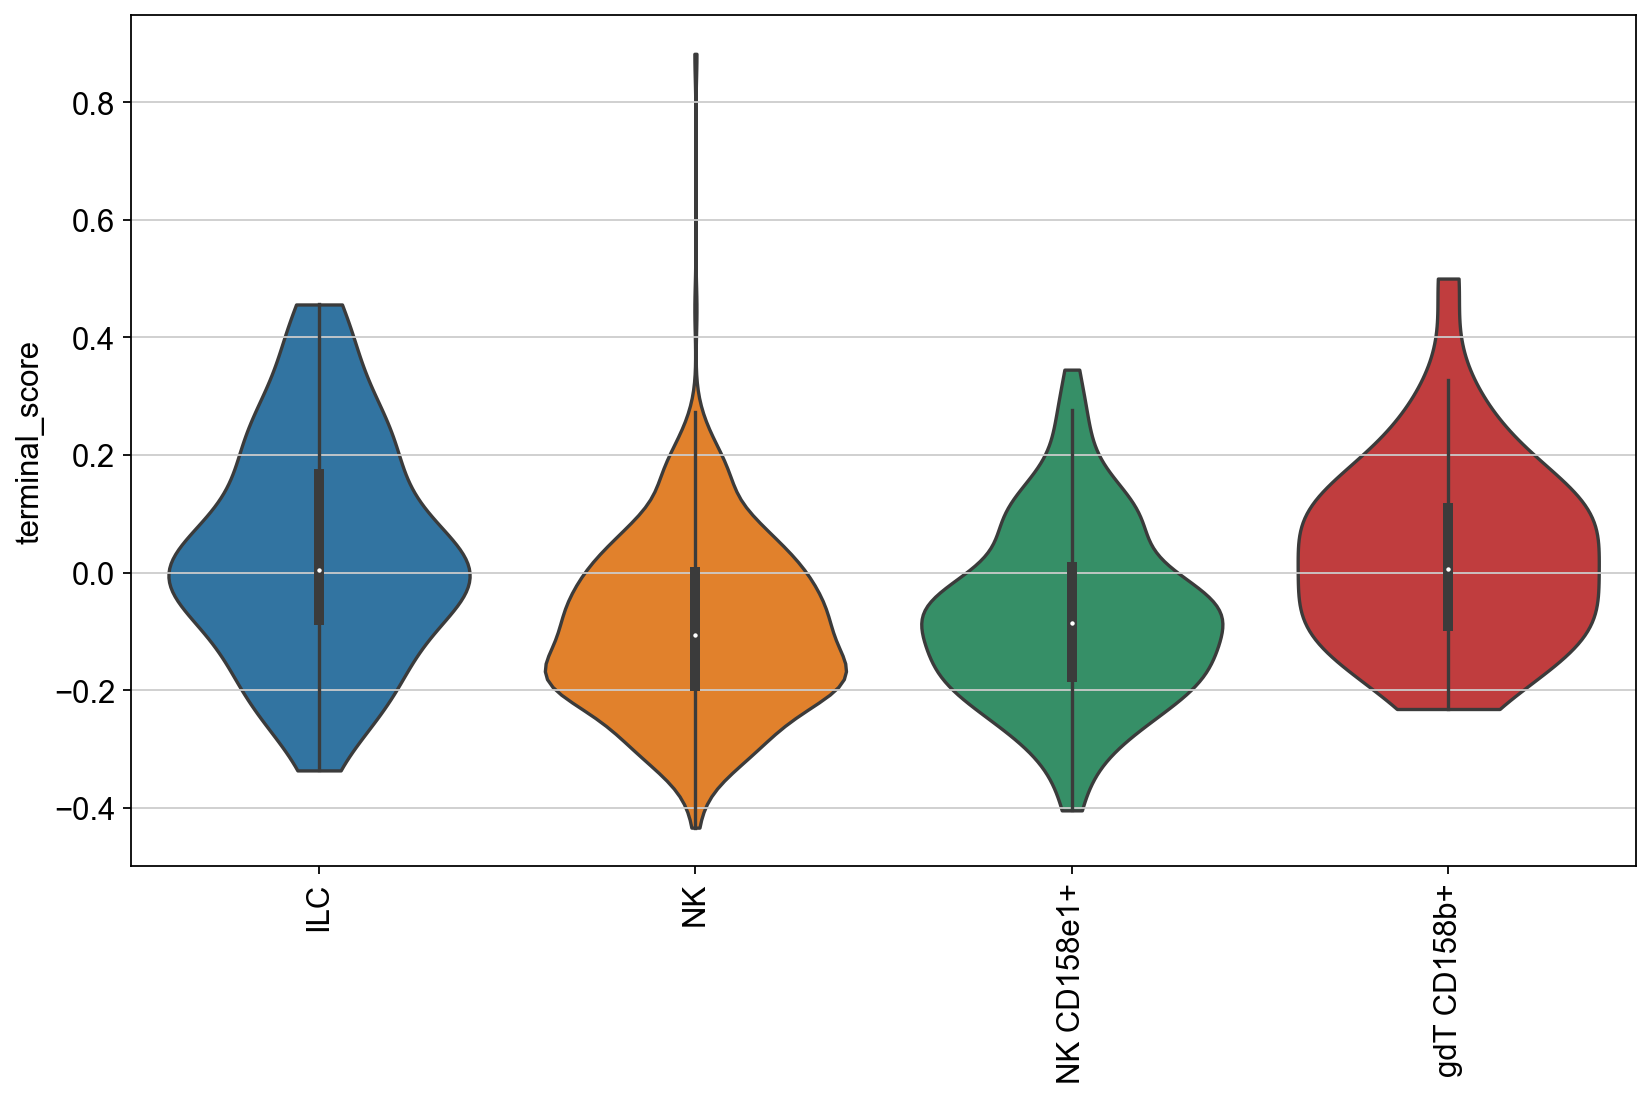

In [53]:
sc.set_figure_params(figsize=(10, 7))

sc.pl.violin(sample_nk, ['terminal_score'], groupby='cell_type', stripplot=False, inner='box', rotation=90)  


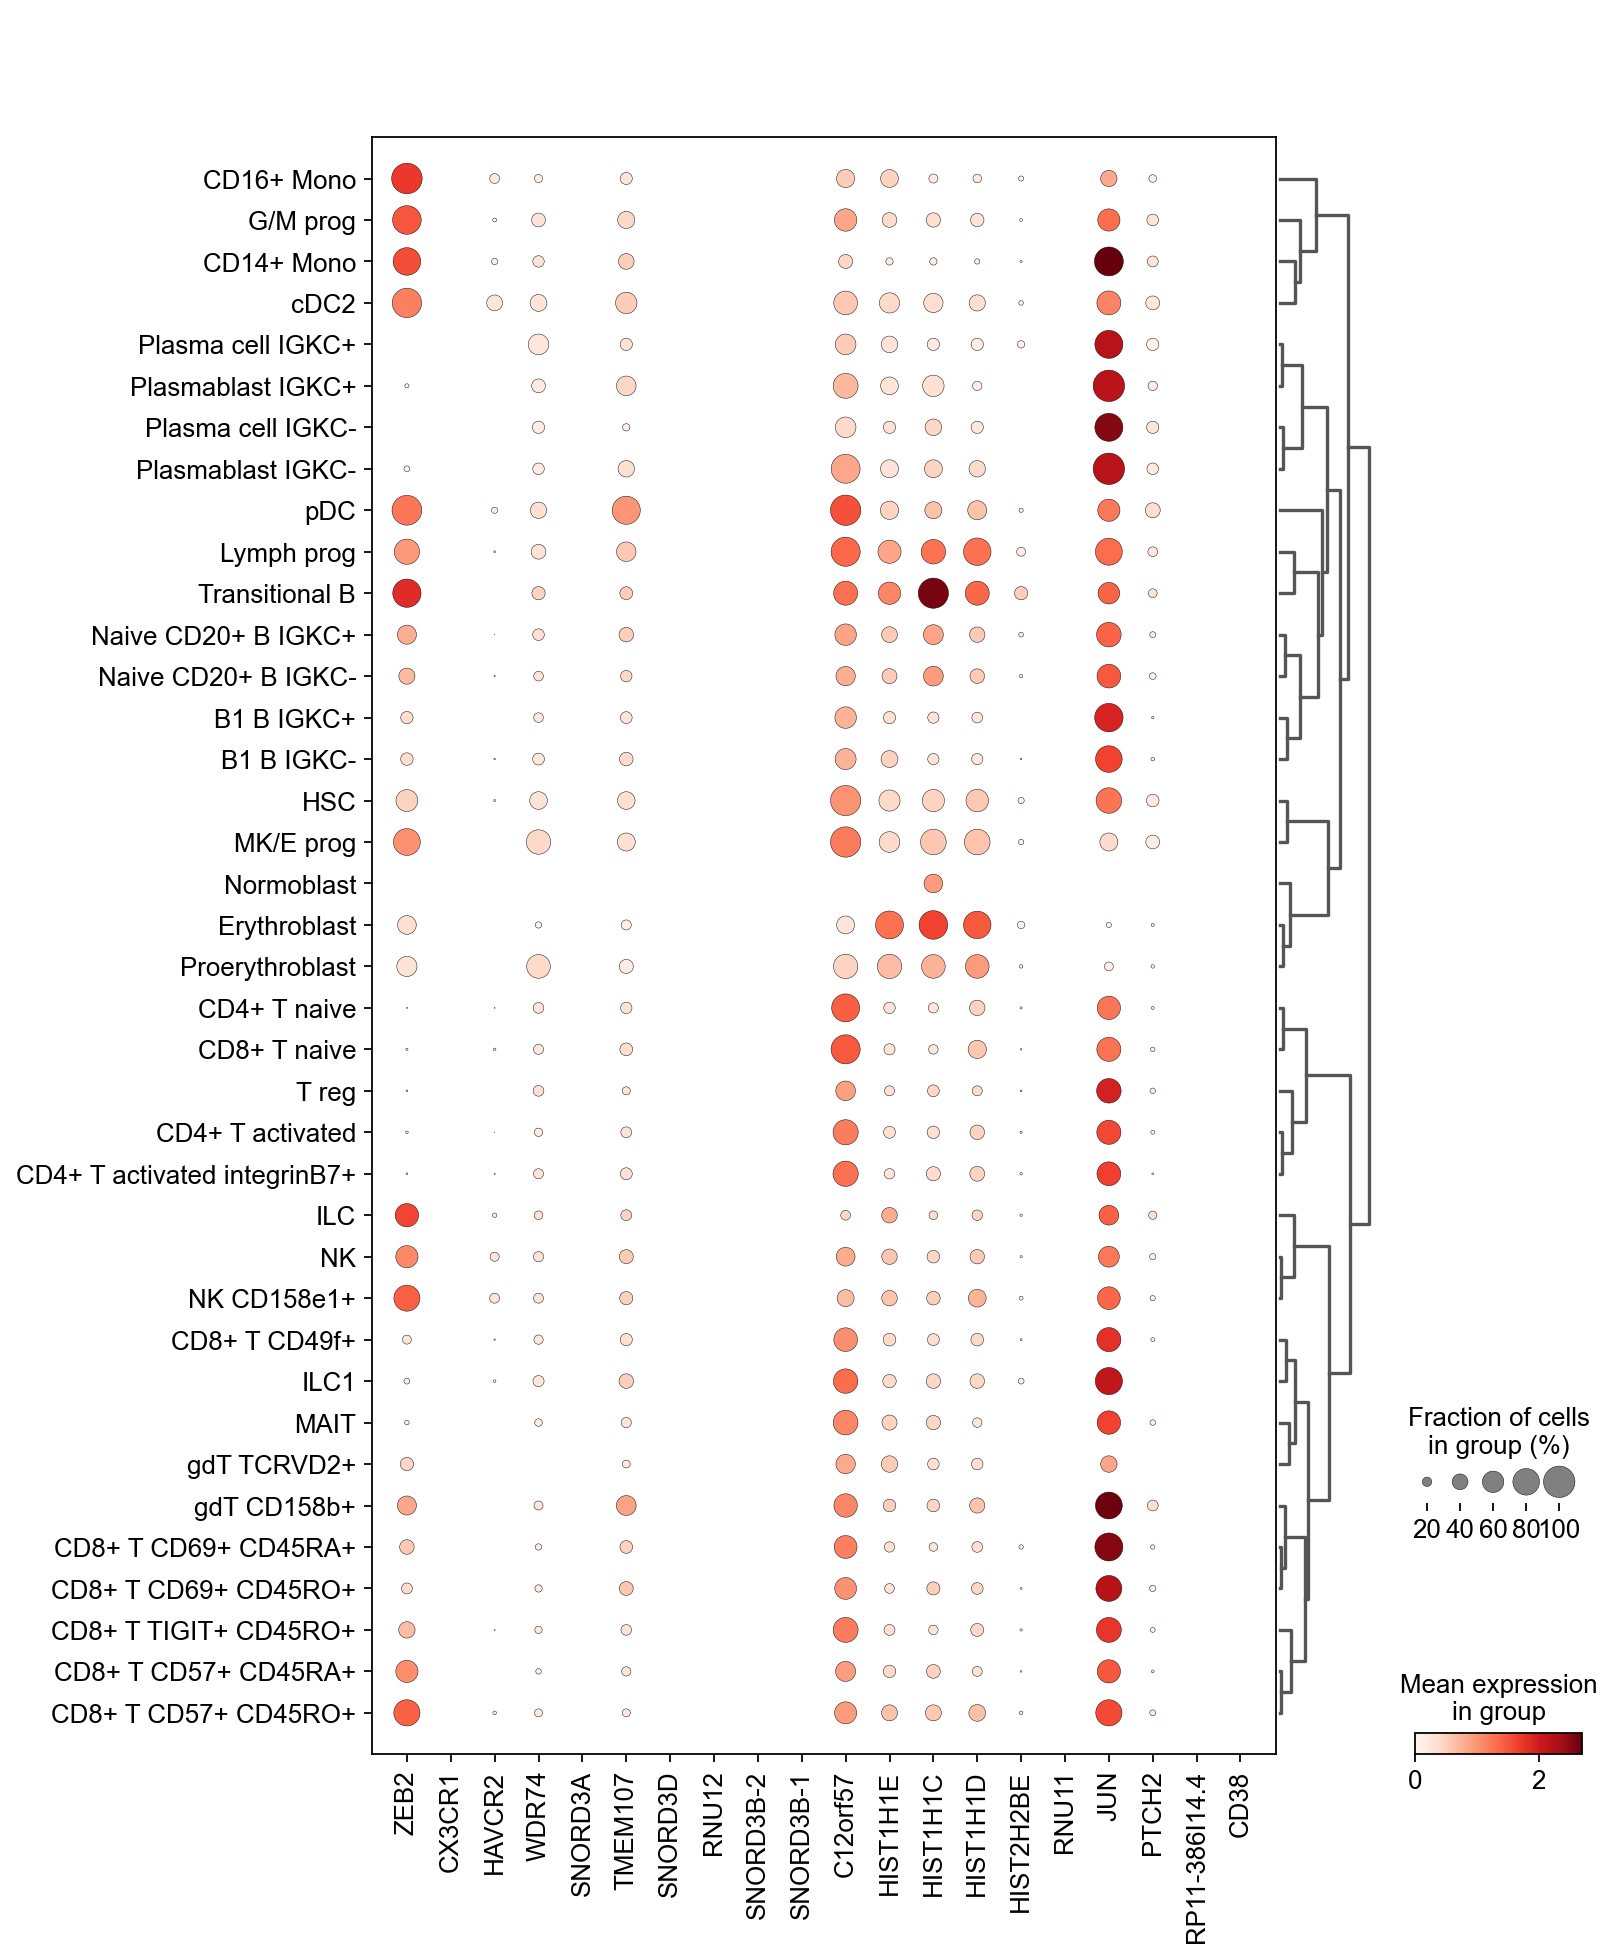

In [55]:
sc.pl.dotplot(eg, terminal_rna_bm , 'cell_type', dendrogram=True)

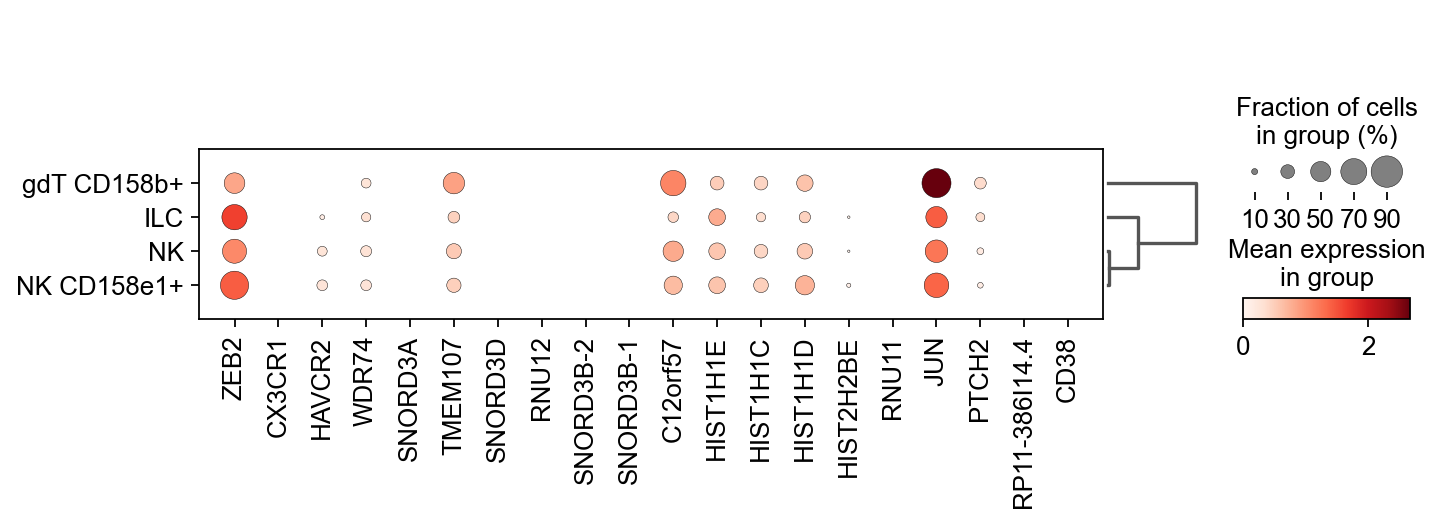

In [54]:
sc.pl.dotplot(sample_nk, terminal_rna_bm , 'cell_type', dendrogram=True)

## 2.6 Inflamed NK cells

According to the paper, this  cluster was mostly composed of cells of one patient, who donored BM. 

In [44]:
inflamed_nk = ['IFIT3', 'IFIT2', 'TNF', 'CD69']


In [45]:
#Calculating gene scores 

sc.tl.score_genes(eg, inflamed_nk, score_name = 'inflamed_score')
sc.tl.score_genes(sample_nk, inflamed_nk, score_name = 'inflamed_score')


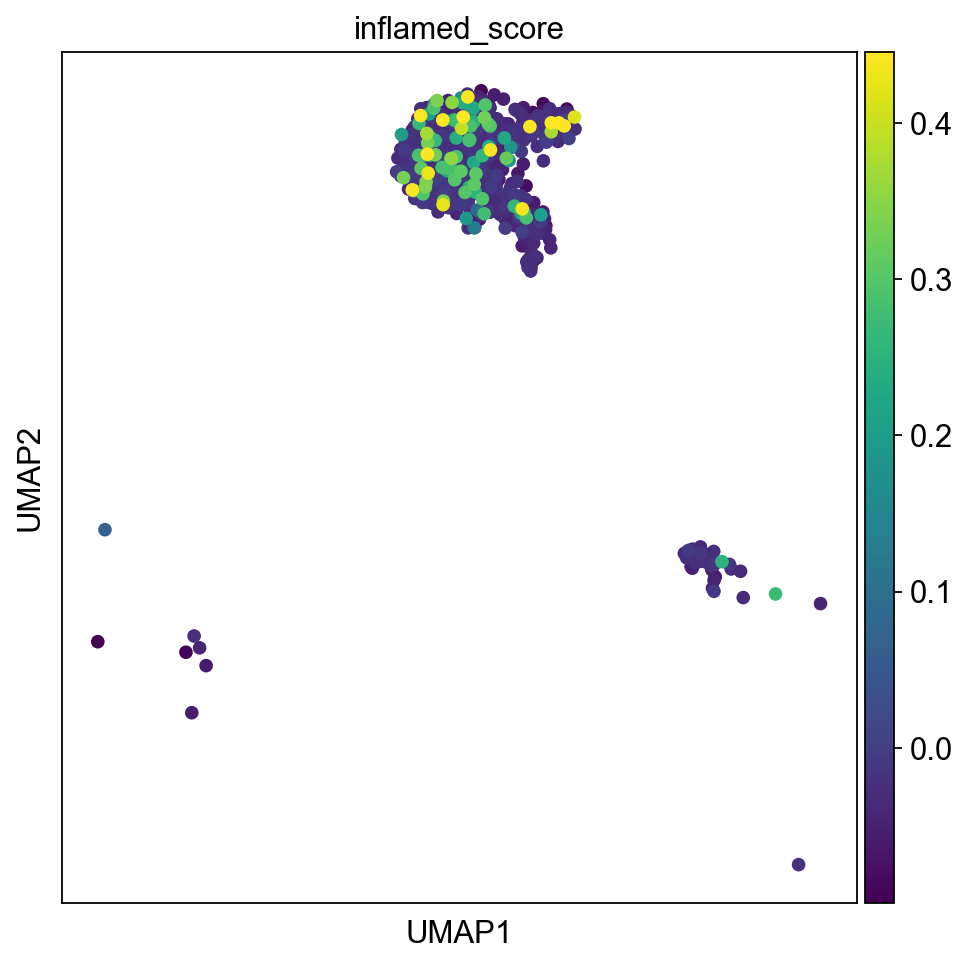

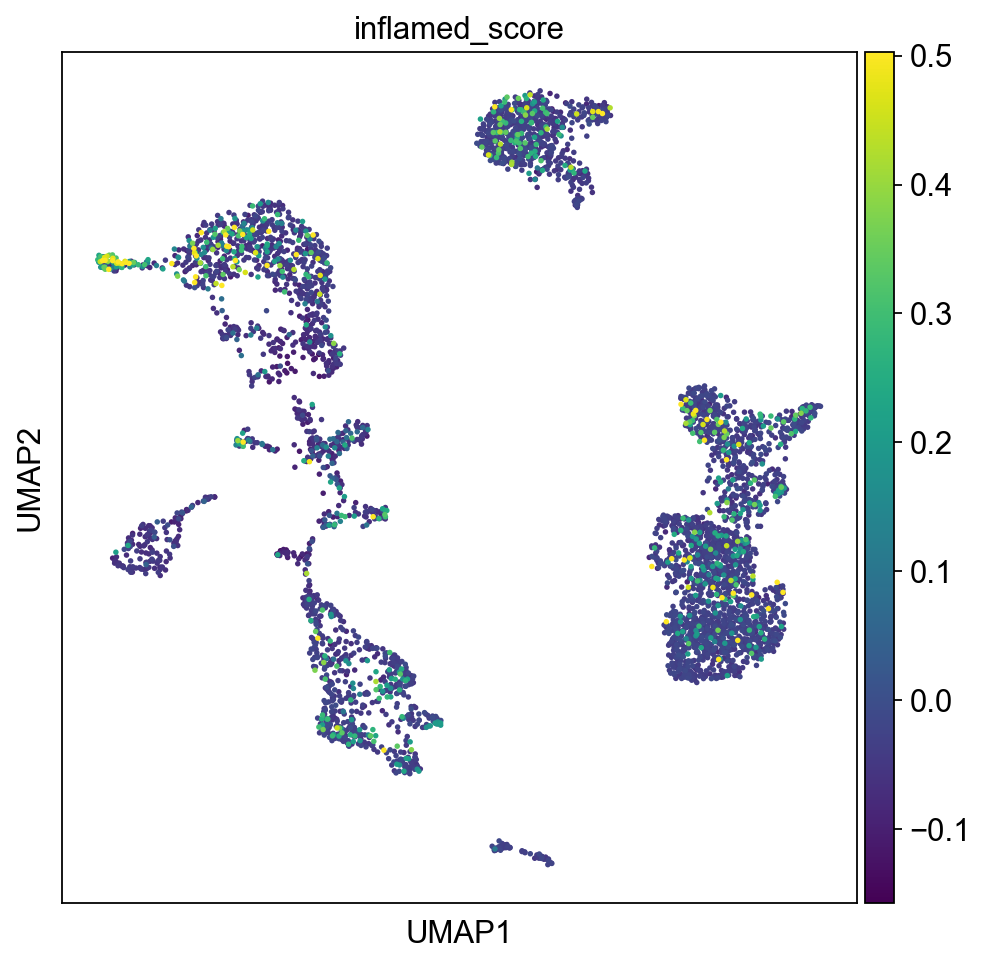

In [46]:
sc.pl.umap(sample_nk, color = ['inflamed_score'], vmax="p99", color_map = 'viridis', ncols=2)

sc.pl.umap(eg, color = ['inflamed_score'], vmax="p99", color_map = 'viridis', ncols=2)



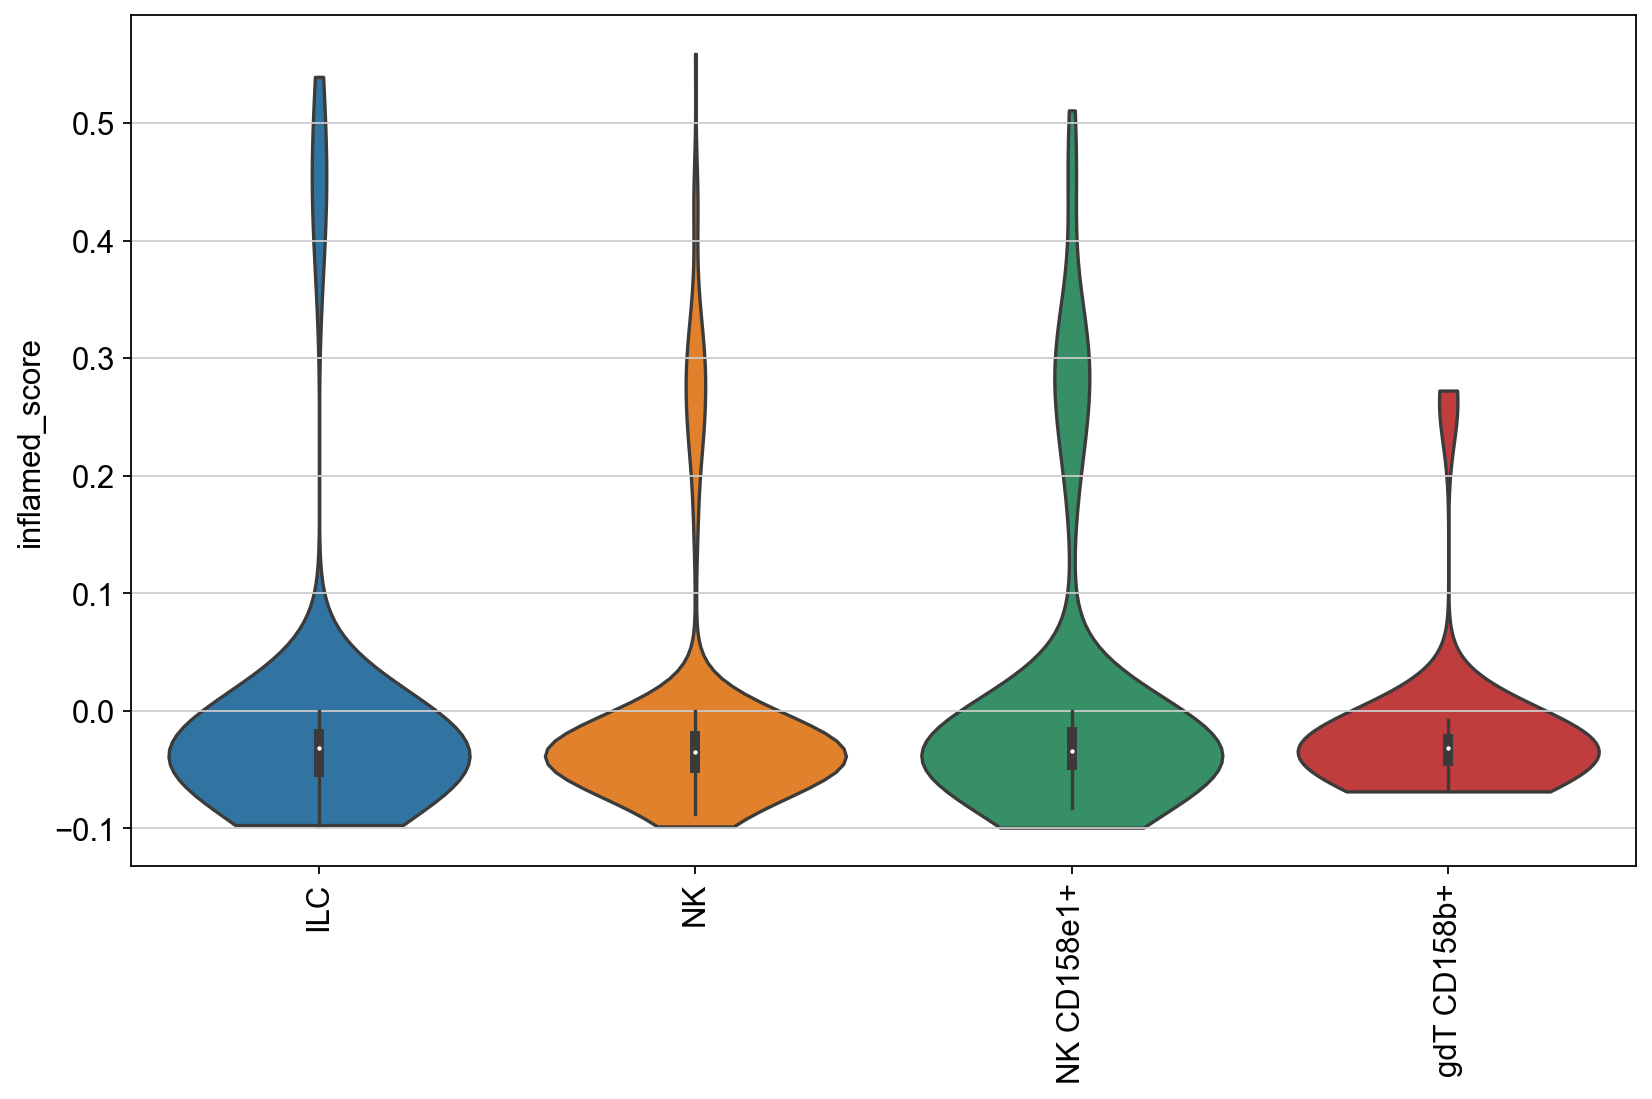

In [56]:
sc.set_figure_params(figsize=(10, 7))

sc.pl.violin(sample_nk, ['inflamed_score'], groupby='cell_type', stripplot=False, inner='box', rotation=90)  



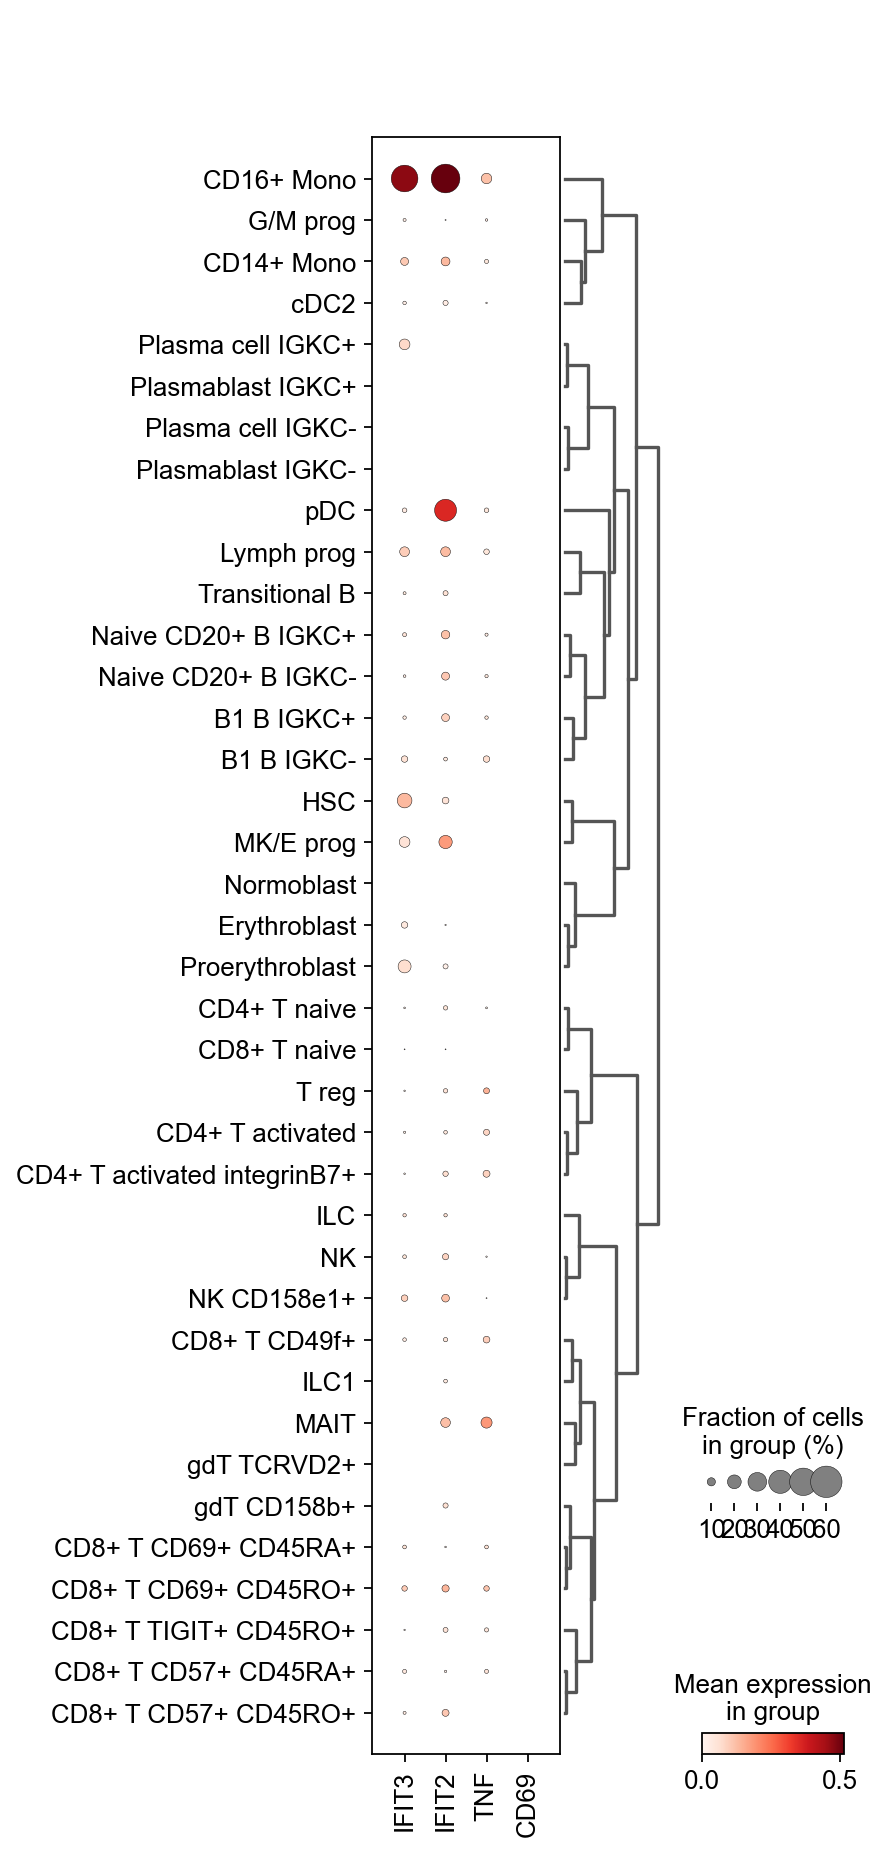

In [58]:
sc.pl.dotplot(eg, inflamed_nk , 'cell_type', dendrogram=True)

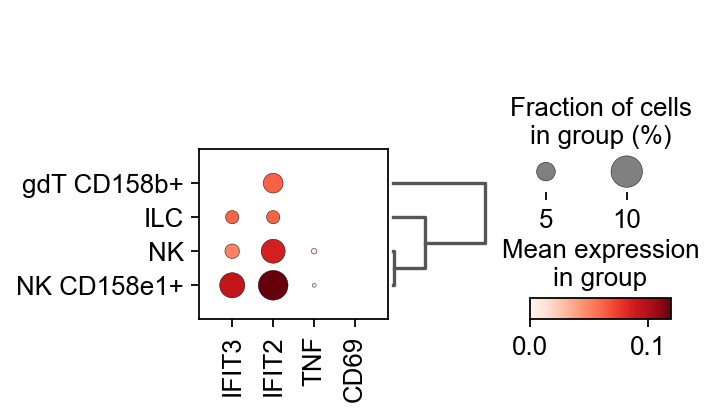

In [57]:
sc.pl.dotplot(sample_nk, inflamed_nk , 'cell_type', dendrogram=True)

## 1.3. Active NK cells

In [47]:

active_nk= ['NFKBIA', 'JUN', 'JUNB', 'ZFP36', 'FOS', 'FOSB', 'DUSP1', 'NR4A2', 'CD69','CXCR4']


In [48]:
#calculating gene scores
sc.tl.score_genes(eg, active_nk, score_name = 'active_score')
sc.tl.score_genes(sample_nk, active_nk, score_name = 'active_score')

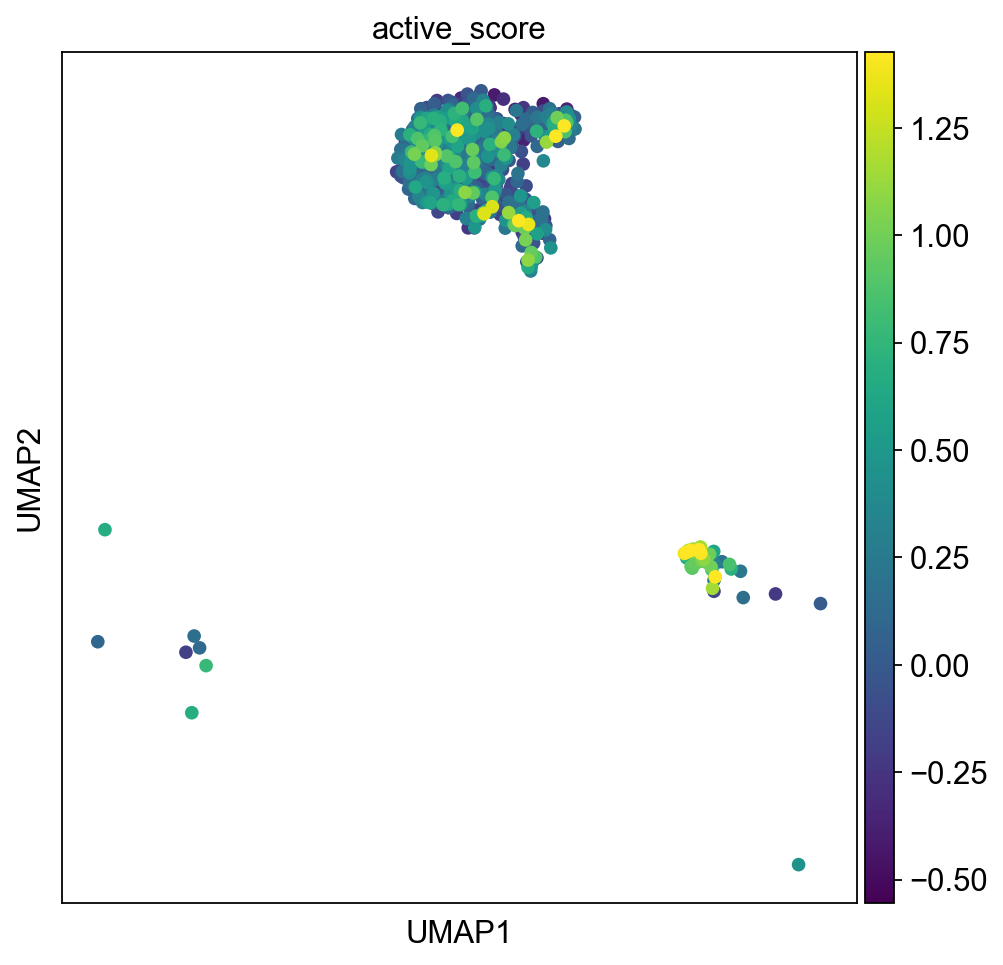

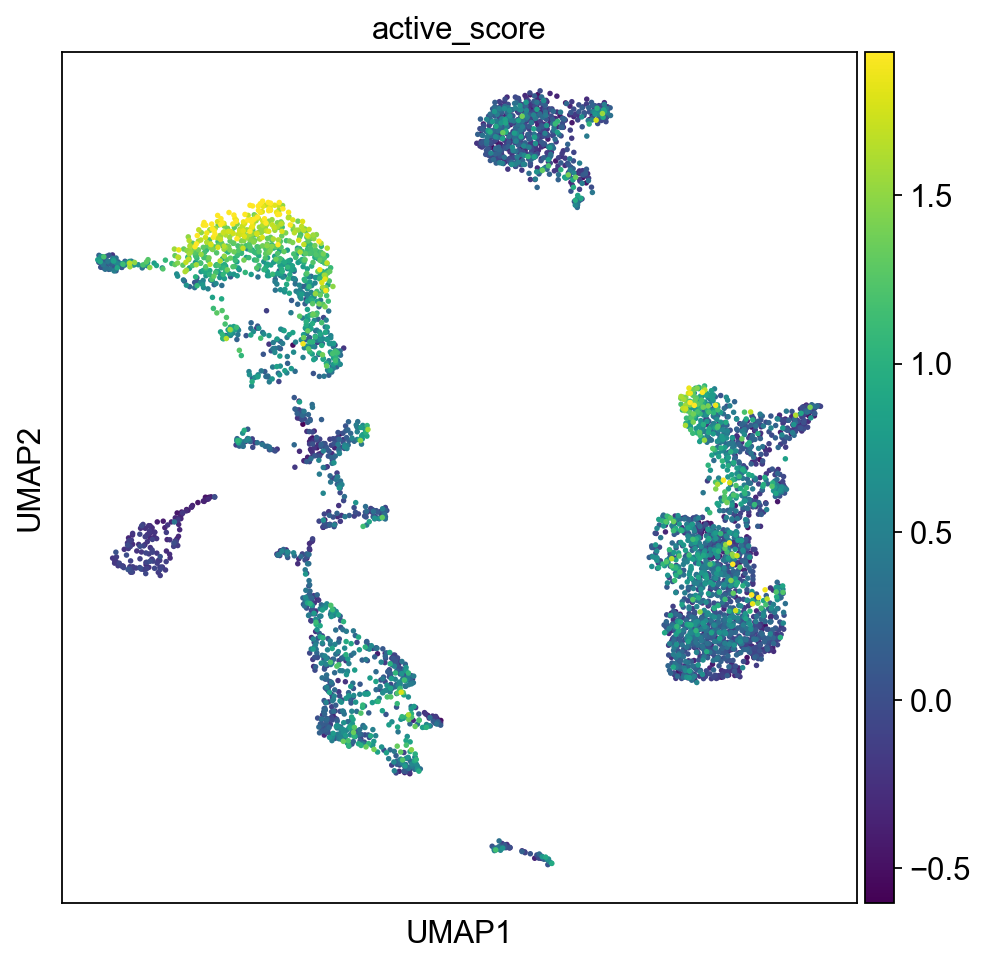

In [49]:
sc.pl.umap(sample_nk, color = ['active_score'], vmax="p99", color_map = 'viridis', ncols=2)

sc.pl.umap(eg, color = ['active_score'], vmax="p99", color_map = 'viridis', ncols=2)


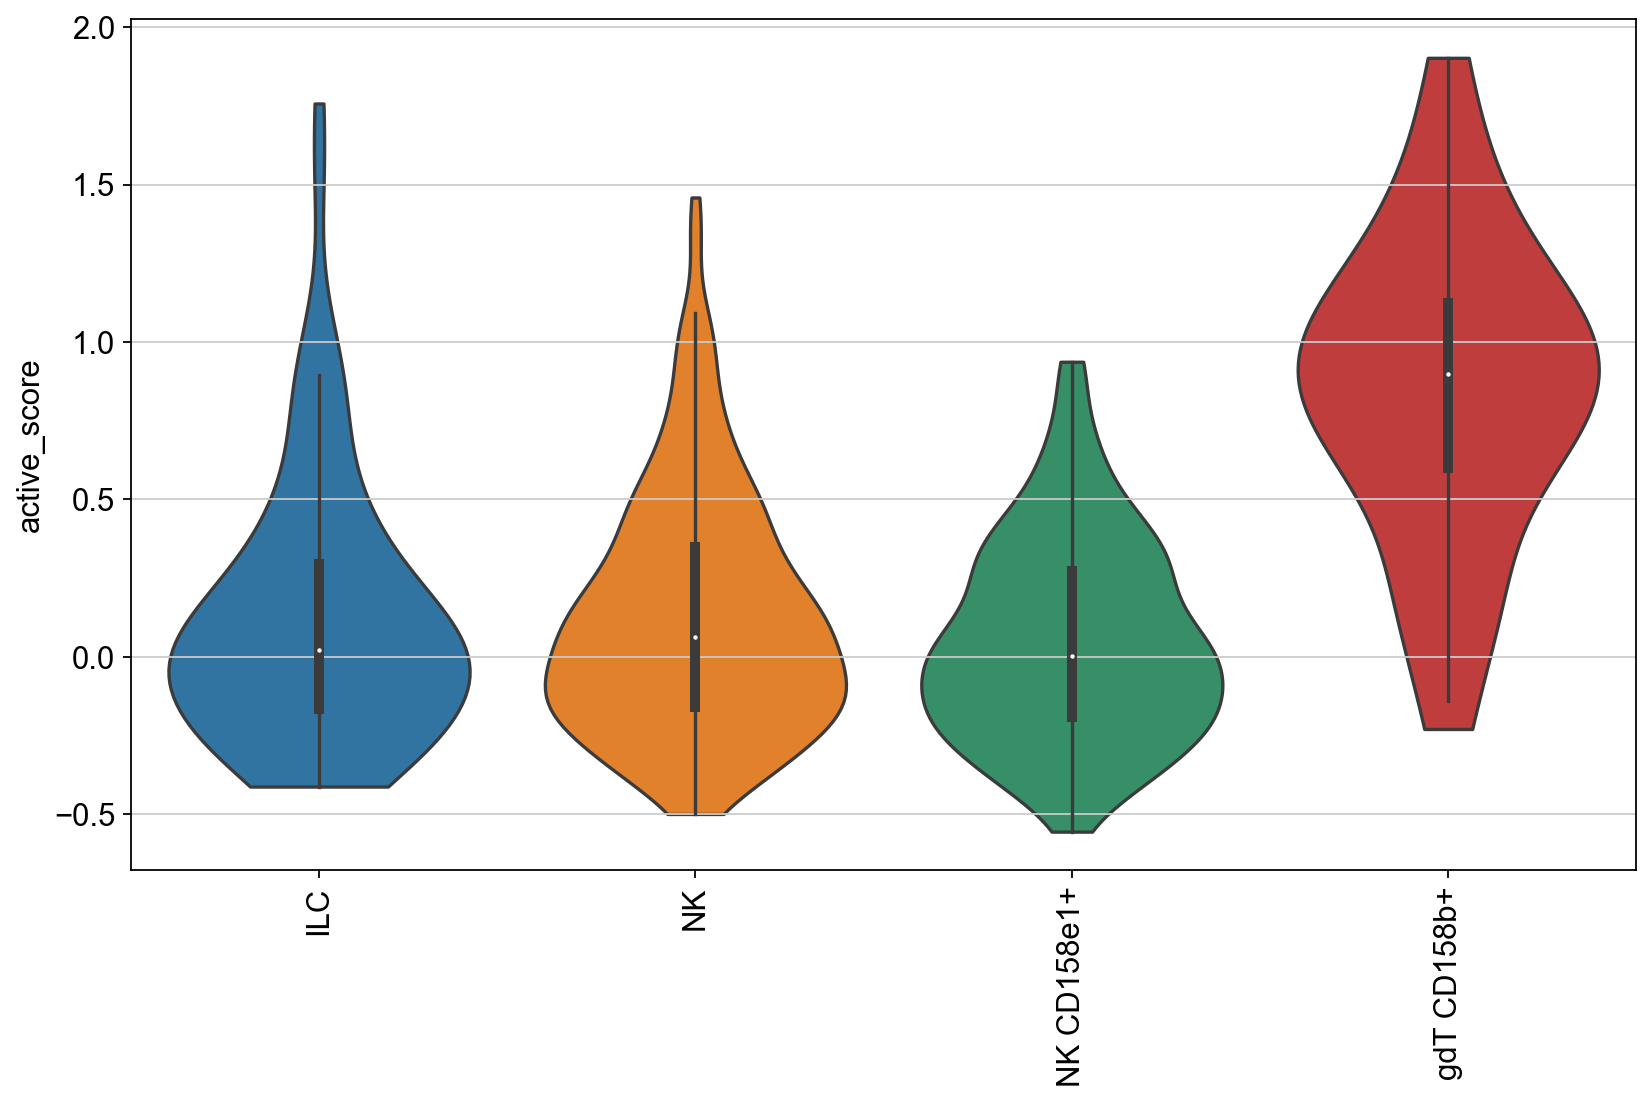

In [60]:
sc.set_figure_params(figsize=(10, 7))

sc.pl.violin(sample_nk, ['active_score'], groupby='cell_type', stripplot=False, inner='box', rotation=90)  



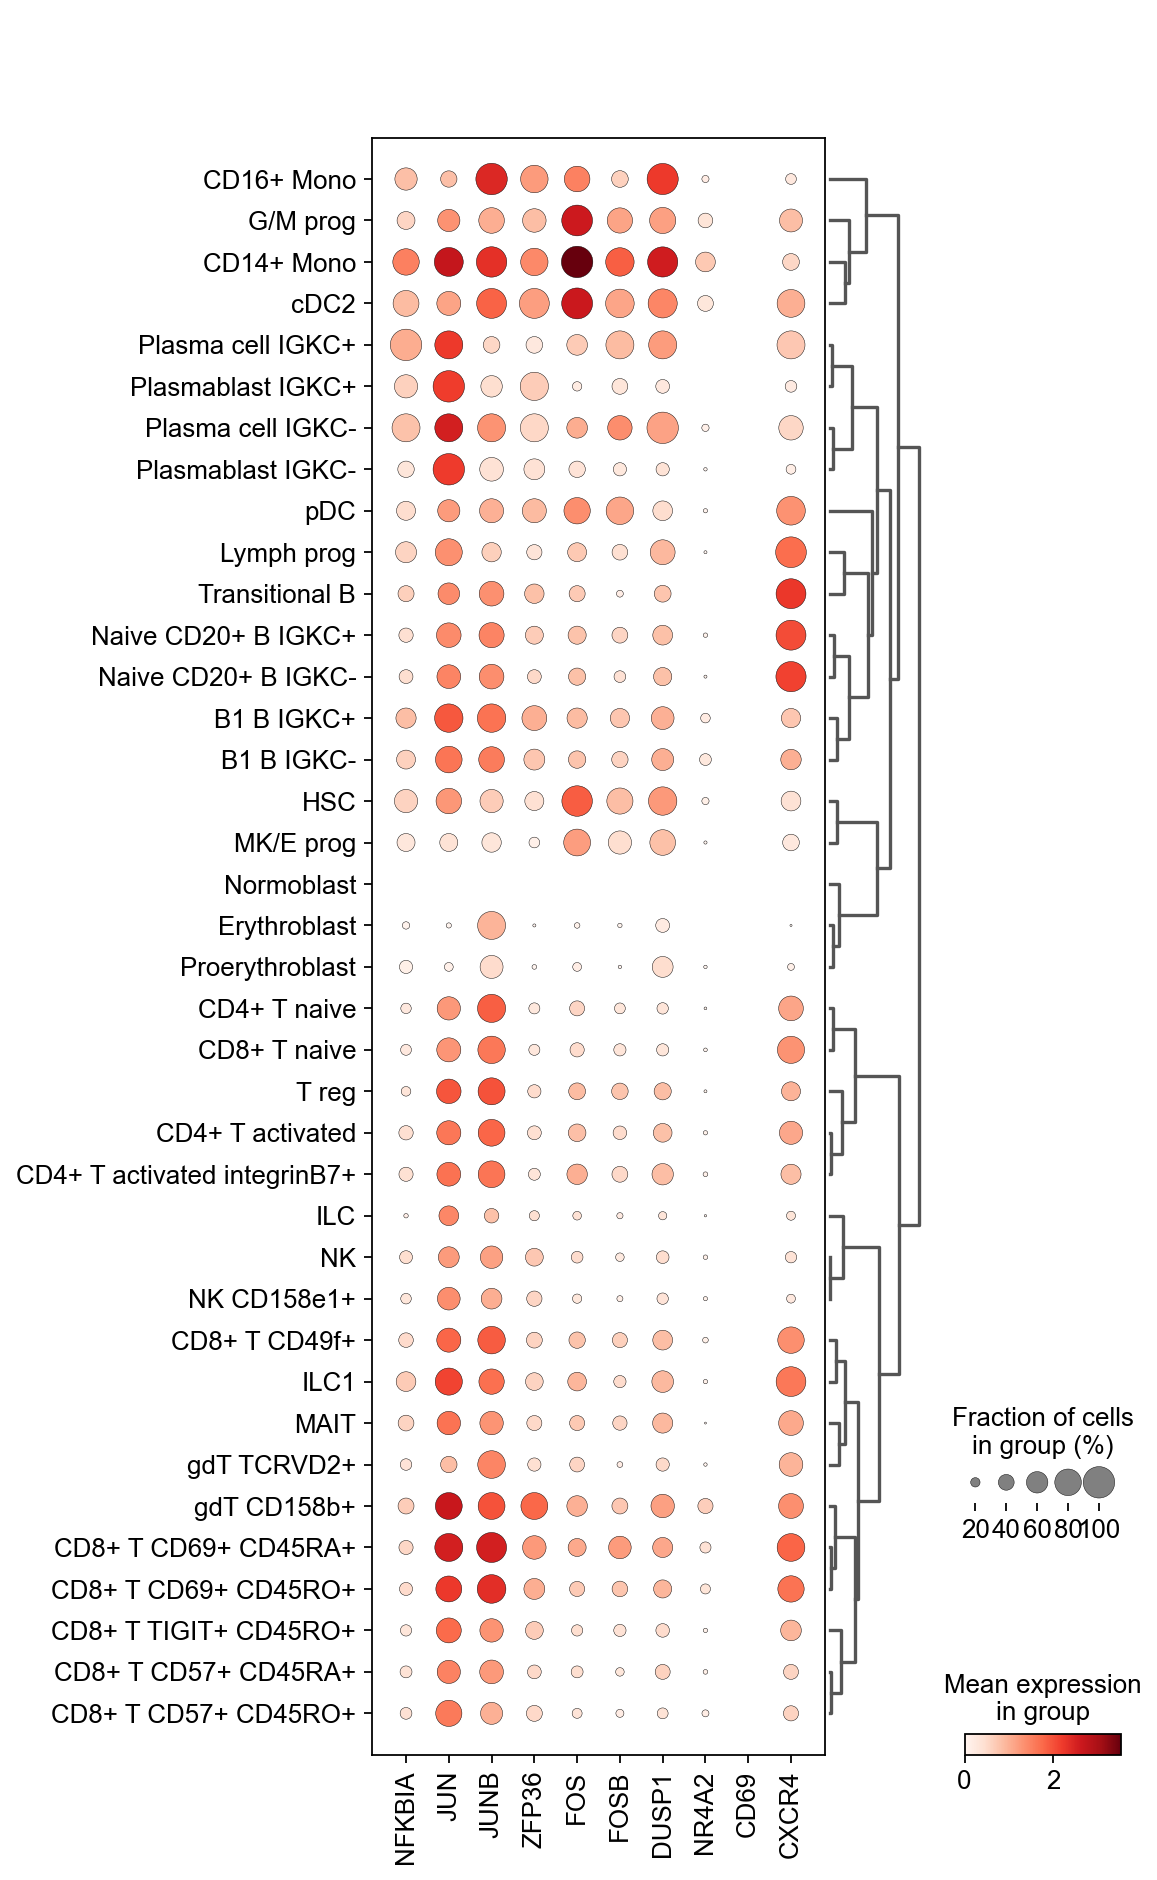

In [62]:
sc.pl.dotplot(eg, active_nk , 'cell_type', dendrogram=True)

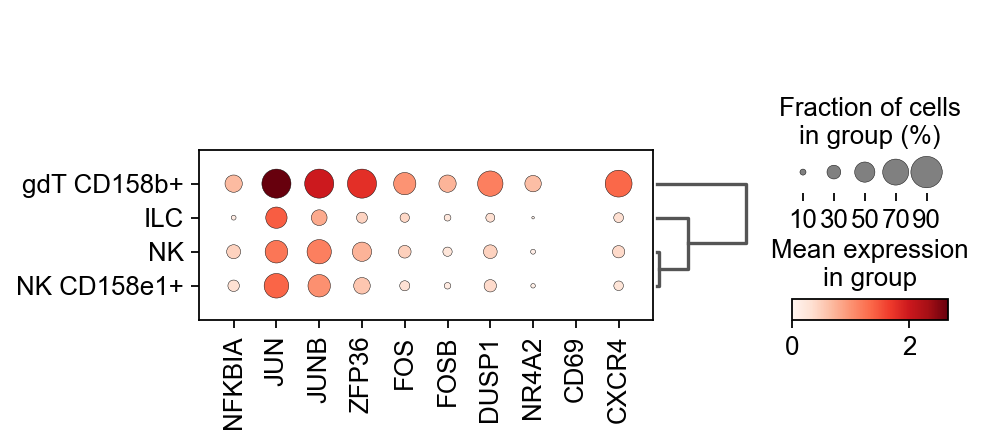

In [61]:
sc.pl.dotplot(sample_nk, active_nk , 'cell_type', dendrogram=True)

# 3 Ranking top 20 expressed genes in each cell type

In [91]:
sc.tl.rank_genes_groups(sample_nk, 'cell_type')

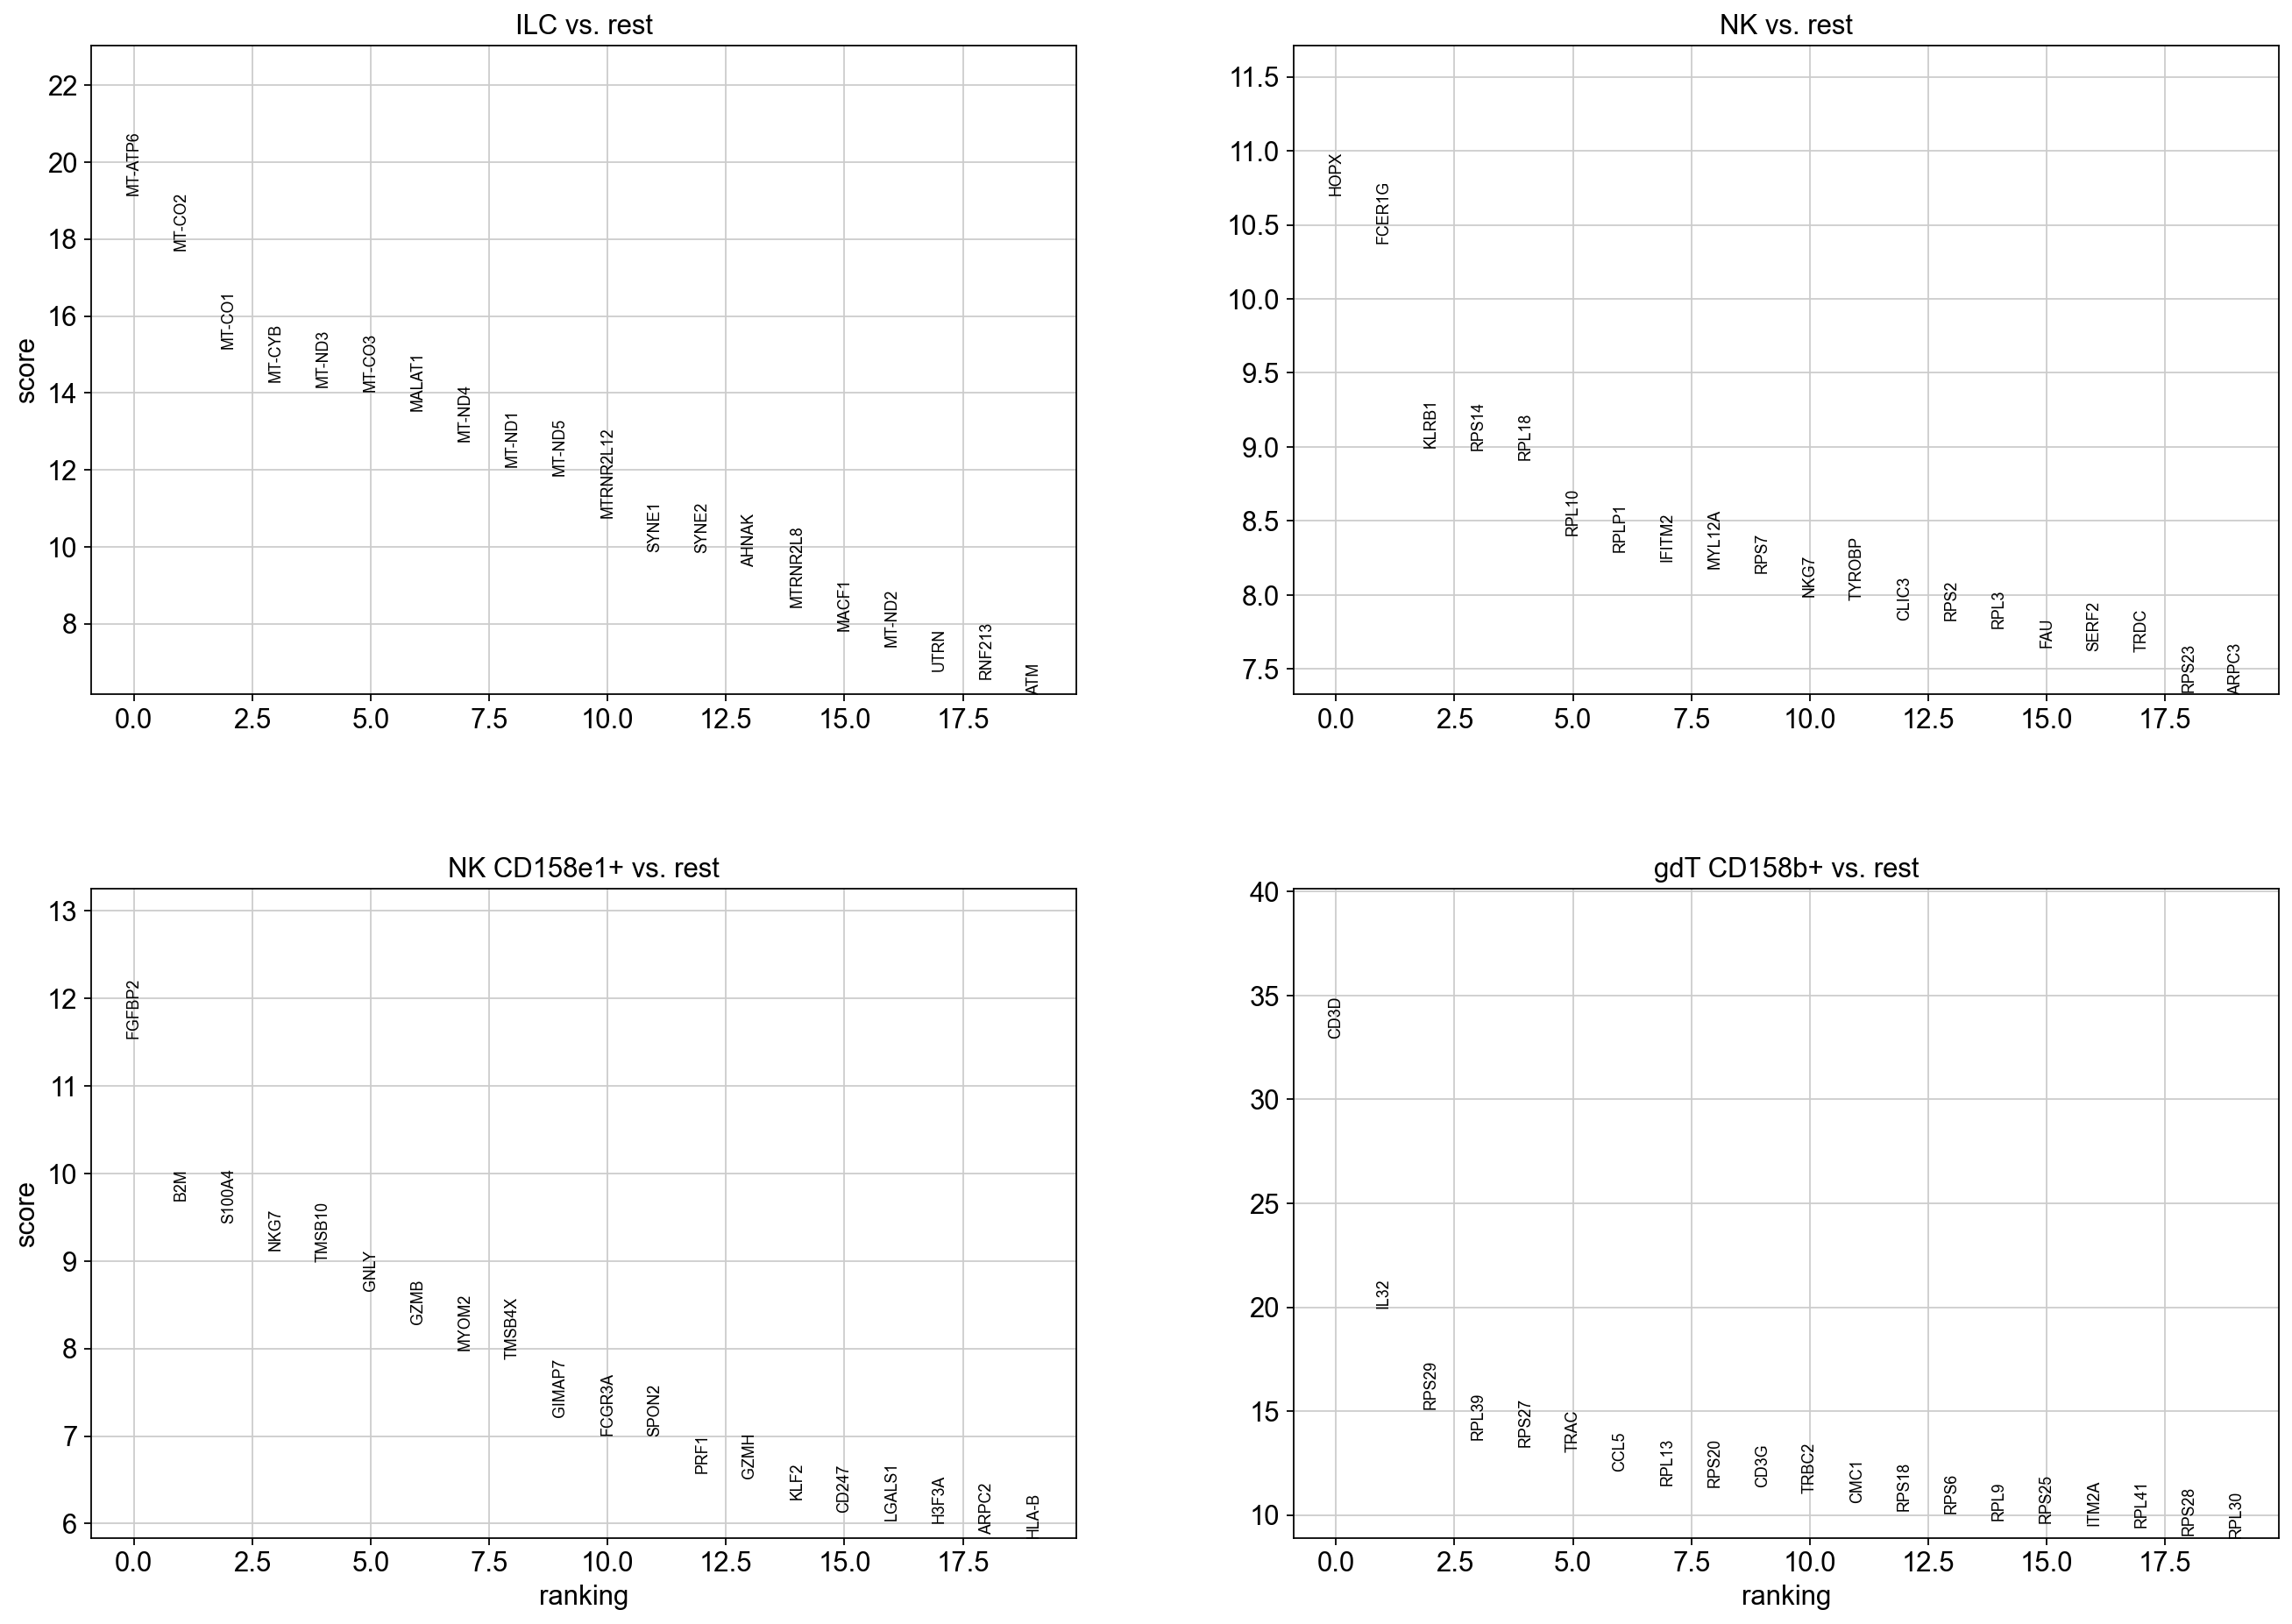

In [94]:
#now also ribosomal and mitochondrial genes are included, these will be removed

sc.pl.rank_genes_groups(sample_nk, n_genes = 20, sharey = False, ncols = 2)